transformer的核心：self-attentions

transformer **优点**：
- 无需对跨数据的时间/空间域的关系作出假设
- 并行计算
- distant item 互相影响彼此的输出
- 可以学习到长距离依赖关系

transformer **缺点**：
- 对于每一个step的xt的输出，是由整个历史信息计算得出，而不再是当前输入和hidden，这可能效率较低
- 如果输入具有时间/空间域的关系，则需要加入位置编码，否则整个model也只能看作是一个词袋模型

目录
* [1.加载数据 建立input pipeline](#)
* [2.位置编码 positional encoding](#)
* [3.掩码 masking](#3)
* [4.scaled dot product attention](#)
* [5.multi-head attention](#)
* [6.point wise feed forward network](#)
* [7.encoder layer](#)
* [8.decoder layer](#)
* [9.encoder](#)
* [10.decoder](#)
* [11.搭建transformer](#)
* [12.设置超参](#)
* [13.优化器](#)
* [14.损失和评价准则](#)
* [15.生成mask](#)
* [16.训练和保存](#)
* [17.评估](#)
* [18.attention的可视化](#)
* [19.总结](#)


## 1.加载数据 建立input pipeline

In [82]:
import torch
from torch import nn
import torchtext

from sklearn.model_selection import train_test_split

import random
import re
# from tqdm import tqdm  # 进度条
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import unicodedata
import datetime
import time
import copy
import math

import sacrebleu
from nltk.translate.bleu_score import sentence_bleu
import pickle
import torch_optimizer as optim
# import adamod
import os
import shutil
import sys

from labml_helpers.module import Module
from labml_nn.transformers import MultiHeadAttention

# print(os.getcwd()) # /home/xijian
file_name = 'transformer_improved_encoder_decoder_zero1'
print(file_name)

train_model_save = '/home/chengkun/jupyter_projects/Magic-NLPer-main/train_save/transformer_improved_encoder_decoder_zero/'
shutil.rmtree(train_model_save)
os.mkdir(train_model_save)

#保存必要结果
begin_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()).replace(' ','_')
# begin_time = '2021-12-15_17:27:45'
print(begin_time)
result_save = '/home/chengkun/jupyter_projects/Magic-NLPer-main/best_save/' + begin_time +'/'
os.mkdir(result_save)

os.system('cp  {} {} {}'.format('/home/chengkun/jupyter_projects/Magic-NLPer-main/re/primer-ez/transformer_improved_encoder_decoder_zero1.py','/home/chengkun/jupyter_projects/Magic-NLPer-main/re/primer-ez/transformer_improved_encoder_decoder_zero1.ipynb',result_save))

transformer_improved_encoder_decoder_zero1
2021-12-15_17:27:45


0

In [83]:
class SquaredReLU(Module):
    def __init__(self):
        super().__init__()
        self.relu = torch.nn.LeakyReLU()
    def forward(self, x: torch.Tensor):
        x = self.relu(x)
        return x * x

class SpatialDepthWiseConvolution(Module):
    def __init__(self, d_k: int, kernel_size: int = 3):
        super().__init__()
        self.kernel_size = kernel_size
        self.conv = torch.nn.Conv1d(in_channels=d_k, out_channels=d_k,
                              kernel_size=(kernel_size,), padding=(kernel_size - 1,), groups=d_k)
    def forward(self, x: torch.Tensor):
        x = x.unsqueeze(-1).permute(1, 0, 3, 2)
        seq_len, batch_size, heads, d_k= x.shape
        x = x.permute(1, 2, 3, 0)
        x = x.view(batch_size * heads, d_k, seq_len)
        x = self.conv(x)
        x = x[:, :, :-(self.kernel_size - 1)]
        x = x.view(batch_size, heads, d_k, seq_len)
        x = x.permute(0, 3, 2, 1) # [batch_size, seq_len, heads, d_k]
        x = x.view(batch_size, seq_len, heads, d_k)
        x = torch.squeeze(x,2)
        return x

# class MultiDConvHeadAttention(MultiHeadAttention):
#     def __init__(self, heads: int, d_model: int, dropout_prob: float = 0.1):
#         super().__init__(heads, d_model, dropout_prob)
        
#         self.query = torch.nn.Sequential(self.query, SpatialDepthWiseConvolution(self.d_k))
#         self.key = torch.nn.Sequential(self.key, SpatialDepthWiseConvolution(self.d_k))
#         self.value = torch.nn.Sequential(self.value, SpatialDepthWiseConvolution(self.d_k))
        
# m = SquaredReLU()
# n = torch.nn.LeakyReLU()
# input = torch.randn(2)
# print(m(input))
# print(n(input)**2)

In [84]:
# class dependency_parsing_Attention(torch.nn.Module):
#     def __init__(self, d_model):
#         super(dependency_parsing_Attention, self).__init__()

#         self.d_model = d_model

#         self.wq = torch.nn.Linear(d_model, d_model)
#         self.wk = torch.nn.Linear(d_model, d_model)
#         self.wv = torch.nn.Linear(d_model, d_model)
#         self.SDWC = SpatialDepthWiseConvolution(d_k=d_model,kernel_size=3)
#         #primer_ez
#         self.final_linear = torch.nn.Linear(d_model, d_model)

#     def forward(self, q, k, v,dependency_parsing_matrix,mask):  # q=k=v=x [b, seq_len, embedding_dim] embedding_dim其实也=d_model
#         batch_size = q.shape[0]
        
#         q = self.wq(q)  # =>[b, seq_len, d_model]
#         print('q',q.shape)
#         q = self.SDWC(q)
#         k = self.wk(k)  # =>[b, seq_len, d_model]
#         k = self.SDWC(k)
#         v = self.wv(v)  # =>[b, seq_len, d_model]
#         v = self.SDWC(v)
# #         print('q:',q.shape)
# #         print('k:',q.shape)
# #         print('v:',q.shape)


#         scaled_attention, attention_weights = dependency_parsing_scaled_dot_product_attention(q, k, v, dependency_parsing_matrix, mask)
#         # => [b, seq_len_q, d_model=512], [b, seq_len_q, seq_len_k]

#         output = self.final_linear(scaled_attention)  # =>[b, seq_len_q, d_model=512]
#         return output, attention_weights  # [b, seq_len_q, d_model=512], [b, seq_len_q, seq_len_k]

# b = 120
# s = 100
# d = 256
# x = torch.rand(b, s, d) # [b,seq_len,d_model]
# dependency_parsing_matrix = torch.rand(b,s,s)
# temp_mha = dependency_parsing_Attention(d_model=d)
# out, attn_weights = temp_mha(x, x, x, dependency_parsing_matrix, mask=None)
# print(out.shape, attn_weights.shape) # [1, 60, 512], [1, 8, 60, 60]

In [85]:
# x = torch.rand(120, 100, 256).unsqueeze(-1) # [b,seq_len,d_model]
# print(x.shape)
# x = x.permute(1, 0, 3, 2)
# print(x.shape)
# x = x.squeeze()
# print(x.shape)

In [87]:
gpu0 = int(sys.argv[1])
gpu1 = int(sys.argv[2])
seed = int(sys.argv[3])

# gpu0 = 3
# gpu1 = 0
# seed = 100
print('gpu0:',gpu0,'gpu1:',gpu1)

gpu0: 3 gpu1: 0


In [88]:
# 设置超参数
os.environ["CUDA_VISIBLE_DEVICES"] = "{},{}".format(gpu0, gpu1)
ngpu = 2
print('ngpu：', ngpu)

batch = 120
print('batch：', batch)

# MAX_LENGTH = d_model//num_heads
MAX_LENGTH = 100
print('MAX_LENGTH：', MAX_LENGTH)
EPOCHS = 35
print('EPOCHS：', EPOCHS)
warm_steps=3000
print('warm_steps：', warm_steps)

use_cuda = torch.cuda.is_available()  #检测是否有可用的gpu
device = torch.device("cuda:0" if (use_cuda and ngpu > 0) else "cpu")

# seed = 256
print('seed：', seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
np.random.seed(seed)  # Numpy module.
random.seed(seed)  # Python random module.
# torch.backends.cudnn.benchmark = False
# torch.backends.cudnn.deterministic = True

ngpu： 2
batch： 120
MAX_LENGTH： 100
EPOCHS： 35
warm_steps： 3000
seed： 100


In [89]:
# 数据读取
# 当你用read_csv读文件的时候，如果文本里包含英文双引号，直接读取会导致行数变少或是直接如下报错停止
# 此时应该对read_csv设置参数控制csv中的引号常量，设定quoting=3或是quoting=csv.QUOTE_NONE”（注：用第二种要先导csv库）然后问题就解决了。

data_dir = '/home/chengkun/jupyter_projects/Magic-NLPer-main/data/' 

data_df = pd.read_csv(data_dir + 'ch_mn_50_nodict.txt',  # 数据格式：英语\t法语，注意我们的任务源语言是法语，目标语言是英语
                      encoding='UTF-8', sep='\t', header=None,quoting=3,
                      names=['mn', 'ch'], index_col=False)

# print(data_df.shape)
# print(data_df.values.shape)
# print(data_df.values[0])
# print(data_df.values[0].shape)
# data_df.head()

In [90]:
# 数据预处理

# 规范化字符串
def normalizeString(s):
    # print(s) # list  ['Go.']
    # s = s[0]
    s = s.lower().strip()
    #s = unicodeToAscii(s)
    #s = re.sub(r"([.!?])", r" \1", s)  # \1表示group(1)即第一个匹配到的 即匹配到'.'或者'!'或者'?'后，一律替换成'空格.'或者'空格!'或者'空格？'
    #s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)  # 非字母以及非.!?的其他任何字符 一律被替换成空格
    s = re.sub(r'[\s]+', " ", s)  # 将出现的多个空格，都使用一个空格代替。例如：w='abc  1   23  1' 处理后：w='abc 1 23 1'
    return s


# print(normalizeString('Va !'))
# print(normalizeString('Go.'))

In [91]:
pairs = [[normalizeString(s) for s in line] for line in data_df.values]

print('pairs num=', len(pairs))
# print(pairs[0])
# print(pairs[0])

pairs num= 500000


In [92]:
# 文件是英译法，我们实现的是法译英，所以进行了reverse，所以pair[1]是英语
# 为了快速训练，仅保留“我是”“你是”“他是”等简单句子，并且删除原始文本长度大于10个标记的样本
def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH 

def filterPairs(pairs):
    # 过滤，并交换句子顺序，得到法英句子对（之前是英法句子对）
    return [[pair[1], pair[0]] for pair in pairs if filterPair(pair)]


pairs = filterPairs(pairs)

print('经过过滤后平行语料数目为：', len(pairs))
# print(pairs[0])
# print(random.choice(pairs))
# print(np.array(pairs).shape)

经过过滤后平行语料数目为： 498921


In [93]:
# 划分数据集：训练集和验证集
##0.0338 0.03485
##50 0.020 0.020
train_test, val_pairs = train_test_split(pairs, test_size=0.020, random_state=1234)
train_pairs, test_pairs = train_test_split(train_test, test_size=0.020, random_state=1234)

print('训练集句子数目：', len(train_pairs))
print('验证集句子数目：', len(val_pairs))
print('测试集句子数目：', len(test_pairs))
# print(test_pairs[0])

训练集句子数目： 479163
验证集句子数目： 9979
测试集句子数目： 9779


In [94]:
# with open(r'/home/chengkun/jupyter_projects/Magic-NLPer-main/data/data_sets/train_pairs','wb') as f:
#     pickle.dump(train_pairs, f)
#     f.close()

# with open(r'/home/chengkun/jupyter_projects/Magic-NLPer-main/data/data_sets/val_pairs','wb') as f:
#     pickle.dump(val_pairs, f)
#     f.close()

# with open(r'/home/chengkun/jupyter_projects/Magic-NLPer-main/data/data_sets/test_pairs','wb') as f:
#     pickle.dump(test_pairs, f)
#     f.close()

In [95]:
# with open(r'/home/chengkun/jupyter_projects/Magic-NLPer-main/data/data_sets/train_pairs','rb') as f:
#     train_pairs = pickle.load(f)
#     f.close()

# with open(r'/home/chengkun/jupyter_projects/Magic-NLPer-main/data/data_sets/val_pairs','rb') as f:
#     val_pairs = pickle.load(f)
#     f.close()

# with open(r'/home/chengkun/jupyter_projects/Magic-NLPer-main/data/data_sets/test_pairs','rb') as f:
#     test_pairs = pickle.load(f)
#     f.close()

# print('训练集句子数目：', len(train_pairs))
# print('验证集句子数目：', len(val_pairs))
# print('测试集句子数目：', len(test_pairs))

In [96]:
tokenizer = lambda x: x.split() # 分词器

SRC_TEXT = torchtext.data.Field(sequential=True,
                                tokenize=tokenizer,
                                # lower=True,
                                fix_length=MAX_LENGTH + 2,
                                preprocessing=lambda x: ['<start>'] + x + ['<end>'],
                                # after tokenizing but before numericalizing
                                # postprocessing # after numericalizing but before the numbers are turned into a Tensor
                                )
TARG_TEXT = torchtext.data.Field(sequential=True,
                                 tokenize=tokenizer,
                                 # lower=True,
                                 fix_length=MAX_LENGTH + 2,
                                 preprocessing=lambda x: ['<start>'] + x + ['<end>'],
                                 )


def get_dataset(pairs, src, targ):
    fields = [('src', src), ('targ', targ)]  # filed信息 fields dict[str, Field])
    examples = []  # list(Example)
    for mn, ch in pairs: # 进度条
        # 创建Example时会调用field.preprocess方法
        examples.append(torchtext.data.Example.fromlist([mn, ch], fields))
    return examples, fields


# examples, fields = get_dataset(pairs, SRC_TEXT, TARG_TEXT)

ds_train = torchtext.data.Dataset(*get_dataset(train_pairs, SRC_TEXT, TARG_TEXT))
ds_val = torchtext.data.Dataset(*get_dataset(val_pairs, SRC_TEXT, TARG_TEXT))
ds_test = torchtext.data.Dataset(*get_dataset(test_pairs, SRC_TEXT, TARG_TEXT))


In [97]:
# # 查看1个样本的信息
print('ds_train')
print(len(ds_train[0].src), ds_train[0].src)
print(len(ds_train[0].targ), ds_train[0].targ)
print('ds_val')
print(len(ds_val[0].src), ds_val[0].src)
print(len(ds_val[0].targ), ds_val[0].targ)
print('ds_test')
print(len(ds_test[0].src), ds_test[0].src)
print(len(ds_test[0].targ), ds_test[0].targ)

ds_train
20 ['<start>', 'ᠴᠢᠯᠠᠭᠤᠨ', 'ᠲᠣᠰᠣ', 'ᠭᠠᠳᠠᠭᠱᠢᠯᠠᠭᠤᠯᠬᠤ', 'ᠤᠯᠤᠰ', 'ᠤ᠋ᠨ', 'ᠵᠣᠬᠢᠶᠠᠨ', 'ᠪᠠᠢᠭᠤᠯᠤᠯᠲᠠ', 'ᠴᠢᠯᠠᠭᠤᠨ', 'ᠲᠣᠰᠣ', 'ᠭᠠᠳᠠᠭᠱᠢᠯᠠᠭᠤᠯᠬᠤ', 'ᠪᠠᠨ', 'ᠵᠣᠭᠰᠣᠭᠠᠨ', '.', 'ᠦᠨ\u180eᠡ', 'ᠥᠰᠬᠦ', 'ᠶ᠋ᠢ', 'ᠬᠦᠯᠢᠶᠡᠨ\u180eᠡ', '.', '<end>']
22 ['<start>', '石', '油', '输', '出', '国', '家', '组', '织', '冻', '结', '石', '油', '输', '出', '.', '价', '格', '看', '涨', '.', '<end>']
ds_val
25 ['<start>', 'ᠴᠠᠭᠠᠨ', 'ᠰᠠᠷ\u180eᠠ', 'ᠶ᠋ᠢᠨ', 'ᠦᠶ\u180eᠡ', 'ᠪᠡᠷ', 'ᠬᠥᠮᠦᠰ', 'ᠬᠠᠭᠤᠴᠢᠨ', 'ᠶᠣᠰᠣ', 'ᠵᠠᠩᠱᠢᠯ', 'ᠢ᠋ᠶ᠋ᠠᠨ', 'ᠪᠠᠷᠢᠮᠲᠠᠯᠠᠵᠤ', 'ᠪᠠᠢᠭ\u180eᠠ', 'ᠪᠥᠭᠡᠳ', 'ᠤᠯᠠᠮ', 'ᠢ᠋ᠶ᠋ᠠᠷ', 'ᠱᠢᠨ\u180eᠡ', 'ᠵᠦᠢᠯ', 'ᠢ᠋', 'ᠡᠷᠢᠨ', 'ᠬᠠᠢᠬᠤ', 'ᠪᠣᠯᠵᠤ', 'ᠪᠠᠢᠨ\u180eᠠ', '.', '<end>']
35 ['<start>', '人', '们', '在', '固', '守', '原', '有', '过', '年', '消', '费', '方', '式', '的', '同', '时', '.', '也', '在', '欣', '赏', '.', '渴', '望', '着', '浪', '漫', '的', '时', '尚', '情', '趣', '.', '<end>']
ds_test
13 ['<start>', 'ᠵᠠᠷᠯᠠᠨ', 'ᠨᠡᠢᠲᠡᠯᠡᠬᠦ', 'ᠬᠤᠭᠤᠴᠠᠭ\u180eᠠ', 'ᠨᠢ', 'ᠬᠣᠷᠢᠨ', 'ᠡᠳᠦᠷ', 'ᠡᠴᠡ', 'ᠳᠤᠲᠠᠭᠤ', 'ᠪᠠᠢᠵᠤ', 'ᠪᠣᠯᠬᠤ', 'ᠦᠭᠡᠢ', '<end>']
13 ['<start>', '公', '示', '时', '间', '不', '得', '少', '于', '二', '十', 

In [98]:
# 构建词典
print('模型大小与词表大小正相关，控制词表大小')
SRC_TEXT.build_vocab(ds_train,min_freq=1)  # 建立词表 并建立token和ID的映射关系
# print(len(SRC_TEXT.vocab))
# print(SRC_TEXT.vocab.itos[0])
# print(SRC_TEXT.vocab.itos[1])
# print(SRC_TEXT.vocab.itos[2])
# print(SRC_TEXT.vocab.itos[3])
# print(SRC_TEXT.vocab.stoi['<start>'])
# print(SRC_TEXT.vocab.stoi['<end>'])

# 模拟decode
res = []
for id in range(20):
    res.append(SRC_TEXT.vocab.itos[id])
print('0-20：'+' '.join(res)+'\n')

TARG_TEXT.build_vocab(ds_train,min_freq=1)

# print(len(TARG_TEXT.vocab))
# print(TARG_TEXT.vocab.itos[0])
# print(TARG_TEXT.vocab.itos[1])
# print(TARG_TEXT.vocab.itos[2])
# print(TARG_TEXT.vocab.itos[3])
# print(TARG_TEXT.vocab.stoi['<start>'])
# print(TARG_TEXT.vocab.stoi['<end>'])

input_vocab_size = len(SRC_TEXT.vocab)
target_vocab_size = len(TARG_TEXT.vocab)

print('input_vocab_size：', input_vocab_size)
print('target_vocab_size：', target_vocab_size)

模型大小与词表大小正相关，控制词表大小
0-20：<unk> <pad> . <end> <start> ᠶ᠋ᠢᠨ ᠤ᠋ᠨ ᠤ᠋ ᠦ᠋ᠨ ᠶ᠋ᠢ ᠢ᠋ ᠳ᠋ᠤ᠌ ᠦ᠌ ᠨᠢ ᠦᠭᠡᠢ ᠳ᠋ᠦ᠍ ᠠ᠋ᠴᠠ ᠤᠯᠤᠰ ᠬᠡᠷᠡᠭᠲᠡᠢ ᠭᠠᠵᠠᠷ

input_vocab_size： 110560
target_vocab_size： 6085


In [99]:
BATCH_SIZE = batch * ngpu

# 构建数据管道迭代器
train_iter, val_iter, test_iter= torchtext.data.Iterator.splits(
    (ds_train, ds_val, ds_test),
    sort_within_batch=True,
    sort_key=lambda x: len(x.src),
    batch_sizes=(BATCH_SIZE, BATCH_SIZE, BATCH_SIZE)
)


# # 查看数据管道信息，此时会触发postprocessing，如果有的话
# for BATCH in train_iter:
#     # 注意，这里text第0维不是batch，而是seq_len
#     print(BATCH.src.shape, BATCH.targ.shape)  # [12,64], [12,64]
#     break

In [100]:
# 将数据管道组织成与torch.utils.data.DataLoader相似的inputs, targets的输出形式
class DataLoader:
    def __init__(self, data_iter):
        self.data_iter = data_iter
        self.length = len(data_iter)  # 一共有多少个batch？

    def __len__(self):
        return self.length

    def __iter__(self):
        # 注意，在此处调整text的shape为batch first
        for batch in self.data_iter:
            yield (torch.transpose(batch.src, 0, 1), torch.transpose(batch.targ, 0, 1))


train_dataloader = DataLoader(train_iter)
val_dataloader = DataLoader(val_iter)
test_dataloader = DataLoader(test_iter)


In [101]:
# 查看数据管道
print('len(train_dataloader):', len(train_dataloader))  # 句子总数/batch数
print('len(val_dataloader):', len(val_dataloader))  # 句子总数/batch数
print('len(test_dataloader):', len(test_dataloader))  # 句子总数/batch数

# for batch_src, batch_targ in train_dataloader:
#     print('batch_src.shape:',batch_src.shape,'\n','batch_targ.shape:',batch_targ.shape)  # [256,12], [256,12]
#     print(batch_src, batch_src.dtype)
#     print(batch_targ, batch_targ.dtype)
#     break


len(train_dataloader): 1997
len(val_dataloader): 42
len(test_dataloader): 41


In [102]:
# dep_train = torch.randn(len(train_pairs),MAX_LENGTH+2,MAX_LENGTH+2)
# dep_val = torch.randn(len(val_pairs),MAX_LENGTH+2,MAX_LENGTH+2)
# dep_test = torch.randn(len(test_pairs),MAX_LENGTH+2,MAX_LENGTH+2)

# for step, (inp, targ) in enumerate(train_dataloader, start=1):
#     print(step)
#     st = (step-1) * inp.shape[0]
#     end = st + inp.shape[0]
#     dependency_matrix = dep_train[st:end,:,:]
#     print(inp.shape)
#     print(targ.shape)
#     print(dependency_matrix.shape)
    
# for step, (inp, targ) in enumerate(test_dataloader, start=1):
#     print(step)
#     st = (step-1) * inp.shape[0]
#     end = st + inp.shape[0]
#     dependency_matrix = dep_test[st:end,:,:]
#     print(inp.shape)
#     print(targ.shape)
#     print(dependency_matrix.shape)

# for step, (inp, targ) in enumerate(val_dataloader, start=1):
#     print(step)
#     st = (step-1) * inp.shape[0]
#     end = st + inp.shape[0]
#     dependency_matrix = dep_val[st:end,:,:]
#     print(inp.shape)
#     print(targ.shape)
#     print(dependency_matrix.shape)

## 2.位置编码 positional encoding
绝对位置编码

由于model中不含有任何recurrence or convolution，所以句子中token的相对位置关系无法体现，
所以就需要在embedding vector中加入position encoding vector（维度相同）。这样每个词的词向量
在 $d_{model}$ 维的空间中，就可以基于meaning和position来计算相似度或相关性

$$\begin{array}{ll} & PE_{(pos,2i)}=sin(pos/10000^{2i/d_{model}}) \\ & PE_{(pos,2i+1)}=cos(pos/10000^{2i/d_{model}})\end{array}$$

**特点：**
- （1）后面位置是前面位置的线性组合，保证了即使位置不是相邻的，也可能有关系（[参考这里](#https://blog.csdn.net/zhulinniao/article/details/104462228/)）
- （2）每个位置的编码又是独特的
- （3）每两个位置的encoding互相做点积，位置越远，点积的值越小，自己和自己点积，值最大

![jupyter-img1](./imgs/im1.jpg)

In [103]:
# 计算角度：pos * 1/(10000^(2i/d))
def get_angles(pos, i, d_model):
    # 2*(i//2)保证了2i，这部分计算的是1/10000^(2i/d)
    angle_rates = 1 / np.power(10000, 2 * (i // 2) / np.float32(d_model))  # => [1, 512]
    return pos * angle_rates  # [50,1]*[1,512]=>[50, 512]


# np.arange()函数返回一个有终点和起点的固定步长的排列，如[1,2,3,4,5]，起点是1，终点是5，步长为1
# 注意：起点终点是左开右闭区间，即start=1,end=6，才会产生[1,2,3,4,5]
# 只有一个参数时，参数值为终点，起点取默认值0，步长取默认值1。
def positional_encoding(position, d_model):  # d_model是位置编码的长度，相当于position encoding的embedding_dim？
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],  # [50, 1]
                            np.arange(d_model)[np.newaxis, :],  # [1, d_model=512]
                            d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])  # 2i
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])  # 2i+2

    pos_encoding = angle_rads[np.newaxis, ...]  # [50,512]=>[1,50,512]
    return torch.tensor(pos_encoding, dtype=torch.float32)

pos_encoding = positional_encoding(50, 512)
# print(pos_encoding.shape) # [1,50,512]

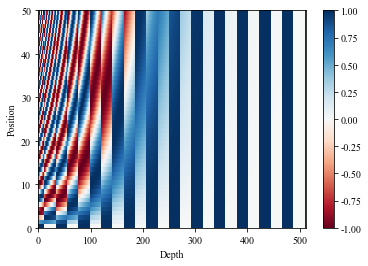

In [104]:
def draw_pos_encoding(pos_encoding):
    plt.figure()
    plt.pcolormesh(pos_encoding[0], cmap='RdBu') # 绘制分类图
    plt.xlabel('Depth')
    plt.xlim((0, 512))
    plt.ylabel('Position')
    plt.colorbar() # 条形bar颜色图例
    plt.savefig(result_save+'pos_encoding.png')
    #plt.show()

draw_pos_encoding(pos_encoding)

## 3.掩码 masking
这里用到的mask有2种：
- padding mask：mask pad，即句子中为pad(value=0)的位置处其mask值为1
- look-ahead mask：mask future token，将当前token后面的词mask掉，只让看到前面的词，即future token位置的mask值为1

**【注意】：** 因为我这里使用的是torchtext里的tokenizer,从前面可以看出它的词表里pad的index=1，而不是常规的0。
这里要特别注意，不然容易出错！

In [105]:
'''
mask 表示掩码，它对某些值进行掩盖，使其在参数更新时不产生效果。
Transformer 模型里面涉及两种 mask，分别是 padding mask 和 sequence mask。
其中，padding mask 在所有的 scaled dot-product attention 里面都需要用到，
而 sequence mask 只有在 decoder 的 self-attention 里面用到。
'''
# 需要mask的位置，替换为1，seq：sentence_len x d_model 
#返回值为：sentence_len x 1 x 1 x d_model 为什么要扩展维度

pad = 1 # 重要！
def create_padding_mask(seq):  # seq [b, seq_len]
    # seq = torch.eq(seq, torch.tensor(0)).float() # pad=0的情况
    seq = torch.eq(seq, torch.tensor(pad)).float()  # pad!=0
    return seq[:, np.newaxis, np.newaxis, :]  # =>[b, 1, 1, seq_len]

# x = torch.tensor([[7, 6, 0, 0, 1],
#                   [1, 2, 3, 0, 0],
#                   [0, 0, 0, 4, 5]])
# print(x.shape) # [3,5]
# print(x)
# mask = create_padding_mask(x)
# print(mask.shape, mask.dtype) # [3,1,1,5]
# print(mask)

# 用train_dataloader的第一个BATCH_SIZE中的input来测试
# for step, (inp, targ) in enumerate(train_dataloader, start=1):
#     print(inp.shape,'\t',targ.shape)
#     print(inp,'\n',targ)
#     break

# input_mask = create_padding_mask(inp)
# targ_mask = create_padding_mask(targ)
# print(input_mask,input_mask.shape)
# print(targ_mask,targ_mask.shape)

In [106]:
# a = []
# b = []
# for step, (inp, targ) in enumerate(test_dataloader):
#     a.append(inp.shape[1])
#     b.append(targ.shape[1])
# #     print(inp,'\n',inp.shape,targ.shape)
# #     break
# print(a)
# print(b)

In [107]:
# pad = 1 # 重要！
# def mn_create_padding_mask(seq):  # seq [b, seq_len]
#     if seq.shape[1] < 10:
#         d = torch.ones([seq.shape[0],10-seq.shape[1]])
#         seq = torch.cat((seq, d), dim=1)
#     print(seq)
#     # seq = torch.eq(seq, torch.tensor(0)).float() # pad=0的情况
#     seq = torch.eq(seq, torch.tensor(pad)).float()  # pad!=0
#     return seq[:, np.newaxis, np.newaxis, :]  # =>[b, 1, 1, seq_len]

# x = torch.tensor([[7, 6, 0, 0, 1],
#                   [1, 2, 3, 0, 0],
#                   [0, 0, 0, 4, 5]])
# print(x.shape) # [3,5]
# print(x)
# mask = mn_create_padding_mask(x)
# print(mask.shape, mask.dtype) # [3,1,1,5]
# print(mask)

# # create two sample vectors
# # inps = torch.randn([64, 161])
# d = torch.ones([3,4])

# # bring d into the same format, and then concatenate tensors
# # new_inps = torch.cat((x, d.unsqueeze(2)), dim=-1)
# new_inps = torch.cat((x,d),dim=1)
# print(new_inps.shape)  # [64, 161, 2]
# print(new_inps)
# print(x.shape[1])

In [108]:
# torch.triu(tensor, diagonal=0) 求上三角矩阵，diagonal默认为0表示主对角线的上三角矩阵
# diagonal>0，则主对角上面的第|diagonal|条次对角线的上三角矩阵
# diagonal<0，则主对角下面的第|diagonal|条次对角线的上三角矩阵
#look-ahead_mask 用于对未预测的token进行掩码，这意味着要预测第三个单词，只会使用第一个和第二个单词。 

def create_look_ahead_mask(size):  # seq_len
    mask = torch.triu(torch.ones((size, size)), diagonal=1)
    # mask = mask.device() #
    return mask  # [seq_len, seq_len]

# x = torch.rand(1,3)
# print(x.shape)
# print(x)
# mask = create_look_ahead_mask(x.shape[1])
# print(mask.shape, mask.dtype)
# print(mask)

# 用train_dataloader的第一个BATCH_SIZE中的target来测试
# for step, (inp, targ) in enumerate(train_dataloader, start=1):
#     print(targ,'\n',inp.shape,targ.shape)
#     break

# look_ahead_mask = create_look_ahead_mask(targ.shape[-1])
# print(look_ahead_mask,look_ahead_mask.shape)

## 4.scaled dot product attention
![jupyter-img2](./imgs/im2.jpg)

$$Attention(Q,K,V)=softmax_{(k)}(\frac{QK^T}{\sqrt{d_k}})V$$

注意：实现时对mask的处理

mask=1的位置是pad或者future token，乘以-1e9（-1*10^9）成为负无穷，经过softmax后会趋于0

In [109]:
def scaled_dot_product_attention(q, k, v, mask=None):
    """
    #计算注意力权重。
    q, k, v 必须具有匹配的前置维度。 且dq=dk
    k, v 必须有匹配的倒数第二个维度，例如：seq_len_k = seq_len_v。
    #虽然 mask 根据其类型（填充或前瞻）有不同的形状，
    #但是 mask 必须能进行广播转换以便求和。

    #参数:
        q: 请求的形状 == (..., seq_len_q, depth)
        k: 主键的形状 == (..., seq_len_k, depth)
        v: 数值的形状 == (..., seq_len_v, depth_v)  seq_len_k = seq_len_v
        mask: Float 张量，其形状能转换成
              (..., seq_len_q, seq_len_k)。默认为None。
    
    # self-attention中q=k=v这点和attention不同，需要先明确
    #q和k相似度计算是为了获取到最合适的值，也就是值的给与注意力的值
    #softmax是为了获取这一系列相似度值的占比（这也就是所谓的权重值）
    #加权是和v也就是本身进行加权，求和是为了获取粒度单词和完整句子之间的关系值计算
    #那么自然而然的，所谓的qkv这一系列操作的目的就是
    #先通过对本身的各个向量值进行相似度计算，然后通过softmax获取本身向量的权重值，在和本身进行加权计算，
    #最后在求和，这样子就获取了一个词和本身所有的词的权重值，然后将所有词的权重值作为输入向量，这也就是所谓的自注意力机制。

    #返回值:
        #输出，注意力权重
    """
    # matmul(a,b)矩阵乘:a b的最后2个维度要能做乘法，即a的最后一个维度值==b的倒数第2个纬度值，
    # 除此之外，其他维度值必须相等或为1（为1时会广播）
    matmul_qk = torch.matmul(q, k.transpose(-1, -2))  # 矩阵乘 =>[..., seq_len_q, seq_len_k]

    # 缩放matmul_qk
    dk = torch.tensor(k.shape[-1], dtype=torch.float32)  # k的深度dk，或叫做depth_k
    scaled_attention_logits = matmul_qk / torch.sqrt(dk)  # [..., seq_len_q, seq_len_k]

    # 将 mask 加入到缩放的张量上(重要！)
    if mask is not None:  # mask: [b, 1, 1, seq_len]
        # mask=1的位置是pad，乘以-1e9（-1*10^9）成为负无穷，经过softmax后会趋于0
        scaled_attention_logits += (mask * -1e9)

    # softmax 在最后一个轴（seq_len_k）上归一化
    attention_weights = torch.nn.functional.softmax(scaled_attention_logits, dim=-1)  # [..., seq_len_q, seq_len_k]

    output = torch.matmul(attention_weights, v)  # =>[..., seq_len_q, depth_v]
    return output, attention_weights  # [..., seq_len_q, depth_v], [..., seq_len_q, seq_len_k]

In [110]:
def mn_scaled_dot_product_attention(q, k, v, m, mask=None):
    """
    #计算注意力权重。
    q, k, v 必须具有匹配的前置维度。 且dq=dk
    k, v 必须有匹配的倒数第二个维度，例如：seq_len_k = seq_len_v。
    #虽然 mask 根据其类型（填充或前瞻）有不同的形状，
    #但是 mask 必须能进行广播转换以便求和。

    #参数:
        q: 请求的形状 == (..., seq_len_q, depth)
        k: 主键的形状 == (..., seq_len_k, depth)
        v: 数值的形状 == (..., seq_len_v, depth_v)  seq_len_k = seq_len_v
        m: 数值的形状 == (..., seq_len_k, seq_len_v) m必须是个方阵
        mask: Float 张量，其形状能转换成
              (..., seq_len_q, seq_len_k)。默认为None。

    #返回值:
        #输出，注意力权重
    """
    # matmul(a,b)矩阵乘:a b的最后2个维度要能做乘法，即a的最后一个维度值==b的倒数第2个纬度值，
    # 除此之外，其他维度值必须相等或为1（为1时会广播）
    matmul_qk = torch.matmul(q, k.transpose(-1, -2))  # 矩阵乘 =>[..., seq_len_q, seq_len_k]

    # 缩放matmul_qk
    dk = torch.tensor(k.shape[-1], dtype=torch.float32)  # k的深度dk，或叫做depth_k
    scaled_attention_logits = matmul_qk / torch.sqrt(dk) # [..., seq_len_q, seq_len_k]
#     print('scaled_attention_logits.shape',scaled_attention_logits.shape)
#     print('m.shape',m.shape)
#     print('q*k^t：', scaled_attention_logits.shape)
    
#     scaled_attention_logits = torch.matmul(scaled_attention_logits,m)
    scaled_attention_logits = scaled_attention_logits * m
#     print('q*k^t*m：', scaled_attention_logits.shape)
    
    # 将 mask 加入到缩放的张量上(重要！)
    if mask is not None:  # mask: [b, 1, 1, seq_len]
        # mask=1的位置是pad，乘以-1e9（-1*10^9）成为负无穷，经过softmax后会趋于0
        scaled_attention_logits += (mask * -1e9)

    # softmax 在最后一个轴（seq_len_k）上归一化
    attention_weights = torch.nn.functional.softmax(scaled_attention_logits, dim=-1)  # [..., seq_len_q, seq_len_k]
    
    output = torch.matmul(attention_weights, v)  # =>[..., seq_len_q, depth_v]
#     print('output：', output.shape)
    return output, attention_weights  # [..., seq_len_q, depth_v], [..., seq_len_q, seq_len_k]

In [111]:
def dependency_parsing_scaled_dot_product_attention(q, k, v, dependency_parsing_matrix, mask=None):
    """
    #计算注意力权重。
    q, k, v 必须具有匹配的前置维度。 且dq=dk
    k, v 必须有匹配的倒数第二个维度，例如：seq_len_k = seq_len_v。
    #虽然 mask 根据其类型（填充或前瞻）有不同的形状，
    #但是 mask 必须能进行广播转换以便求和。

    #参数:
        q: 请求的形状 == (..., seq_len_q, depth)
        k: 主键的形状 == (..., seq_len_k, depth)
        v: 数值的形状 == (..., seq_len_v, depth_v)  seq_len_k = seq_len_v
        mask: Float 张量，其形状能转换成
              (..., seq_len_q, seq_len_k)。默认为None。
    
    # self-attention中q=k=v这点和attention不同，需要先明确
    #q和k相似度计算是为了获取到最合适的值，也就是值的给与注意力的值
    #softmax是为了获取这一系列相似度值的占比（这也就是所谓的权重值）
    #加权是和v也就是本身进行加权，求和是为了获取粒度单词和完整句子之间的关系值计算
    #那么自然而然的，所谓的qkv这一系列操作的目的就是
    #先通过对本身的各个向量值进行相似度计算，然后通过softmax获取本身向量的权重值，在和本身进行加权计算，
    #最后在求和，这样子就获取了一个词和本身所有的词的权重值，然后将所有词的权重值作为输入向量，这也就是所谓的自注意力机制。

    #返回值:
        #输出，注意力权重
    """
    # matmul(a,b)矩阵乘:a b的最后2个维度要能做乘法，即a的最后一个维度值==b的倒数第2个纬度值，
    # 除此之外，其他维度值必须相等或为1（为1时会广播）
    matmul_qk = torch.matmul(q, k.transpose(-1, -2))  # 矩阵乘 =>[..., seq_len_q, seq_len_k]
#     print('matmul_qk:', matmul_qk.size())
#     print('dependency_parsing_matrix:', dependency_parsing_matrix.size())
    matmul_qk = matmul_qk + dependency_parsing_matrix

    # 缩放matmul_qk
    dk = torch.tensor(k.shape[-1], dtype=torch.float32)  # k的深度dk，或叫做depth_k
    scaled_attention_logits = matmul_qk / torch.sqrt(dk)  # [..., seq_len_q, seq_len_k]
#     print('scaled_attention_logits.shape:', scaled_attention_logits.shape)
    # 将 mask 加入到缩放的张量上(重要！)
    if mask is not None:  # mask: [b, 1, 1, seq_len]
#         print('mask.shape', mask.shape)
        mask = mask.reshape(-1,mask.shape[-1],mask.shape[-1])
        # mask=1的位置是pad，乘以-1e9（-1*10^9）成为负无穷，经过softmax后会趋于0
        scaled_attention_logits += (mask * -1e9)
    
    # softmax 在最后一个轴（seq_len_k）上归一化
    attention_weights = torch.nn.functional.softmax(scaled_attention_logits, dim=-1)  # [..., seq_len_q, seq_len_k]

    output = torch.matmul(attention_weights, v)  # =>[..., seq_len_q, depth_v]
#     print('output.shape',output.shape)
    return output, attention_weights  # [..., seq_len_q, depth_v], [..., seq_len_q, seq_len_k]

In [112]:
# # 原来的
# class dependency_parsing_Attention(torch.nn.Module):
#     def __init__(self, d_model):
#         super(dependency_parsing_Attention, self).__init__()

#         self.d_model = d_model

#         self.wq = torch.nn.Linear(d_model, d_model)
#         self.wk = torch.nn.Linear(d_model, d_model)
#         self.wv = torch.nn.Linear(d_model, d_model)
#         #primer_ez
#         self.final_linear = torch.nn.Linear(d_model, d_model)

#     def forward(self, q, k, v,dependency_parsing_matrix,mask):  # q=k=v=x [b, seq_len, embedding_dim] embedding_dim其实也=d_model
#         batch_size = q.shape[0]

#         q = self.wq(q)  # =>[b, seq_len, d_model]
#         k = self.wk(k)  # =>[b, seq_len, d_model]
#         v = self.wv(v)  # =>[b, seq_len, d_model]
# #         print('q:',q.shape)
# #         print('k:',q.shape)
# #         print('v:',q.shape)

#         scaled_attention, attention_weights = dependency_parsing_scaled_dot_product_attention(q, k, v, dependency_parsing_matrix, mask)
#         # => [b, seq_len_q, d_model=512], [b, seq_len_q, seq_len_k]

#         output = self.final_linear(scaled_attention)  # =>[b, seq_len_q, d_model=512]
#         return output, attention_weights  # [b, seq_len_q, d_model=512], [b, seq_len_q, seq_len_k]


# # x = torch.rand(2, 5, 6) # [b,seq_len,d_model,]
# # dependency_parsing_matrix = torch.rand(2,5,5)

# # temp_mha = dependency_parsing_Attention(d_model=6)

# # out, attn_weights = temp_mha(x, x, x, dependency_parsing_matrix, mask=None)
# # print(out.shape, attn_weights.shape) # [1, 60, 512], [1, 8, 60, 60]

In [113]:
# 加入premer-ez的
class dependency_parsing_Attention(torch.nn.Module):
    def __init__(self, d_model):
        super(dependency_parsing_Attention, self).__init__()

        self.d_model = d_model

        self.wq = torch.nn.Linear(d_model, d_model)
        self.wk = torch.nn.Linear(d_model, d_model)
        self.wv = torch.nn.Linear(d_model, d_model)
        self.SDWC = SpatialDepthWiseConvolution(d_k=d_model,kernel_size=3)
        #primer_ez
        self.final_linear = torch.nn.Linear(d_model, d_model)

    def forward(self, q, k, v,dependency_parsing_matrix,mask):  # q=k=v=x [b, seq_len, embedding_dim] embedding_dim其实也=d_model
        batch_size = q.shape[0]
        
        q = self.wq(q)  # =>[b, seq_len, d_model]
#         print('q',q.shape)
        q = self.SDWC(q)
        k = self.wk(k)  # =>[b, seq_len, d_model]
        k = self.SDWC(k)
        v = self.wv(v)  # =>[b, seq_len, d_model]
        v = self.SDWC(v)
#         print('q:',q.shape)
#         print('k:',q.shape)
#         print('v:',q.shape)


        scaled_attention, attention_weights = dependency_parsing_scaled_dot_product_attention(q, k, v, dependency_parsing_matrix, mask)
        # => [b, seq_len_q, d_model=512], [b, seq_len_q, seq_len_k]

        output = self.final_linear(scaled_attention)  # =>[b, seq_len_q, d_model=512]
        return output, attention_weights  # [b, seq_len_q, d_model=512], [b, seq_len_q, seq_len_k]

# b = 120
# s = 100
# d = 256
# x = torch.rand(b, s, d) # [b,seq_len,d_model]
# dependency_parsing_matrix = torch.rand(b,s,s)
# temp_mha = dependency_parsing_Attention(d_model=d)
# out, attn_weights = temp_mha(x, x, x, dependency_parsing_matrix, mask=None)
# print(out.shape, attn_weights.shape) # [1, 60, 512], [1, 8, 60, 60]

In [114]:
# def print_out(q, k, v, m):
#     temp_out, temp_attn = mn_scaled_dot_product_attention(q, k, v, m, None)
#     print('Attention weights are:')
#     print(temp_attn)
#     print('Output is:')
#     print(temp_out)

# np.set_printoptions(suppress=True) # 设置不以科学计数法的形式显示数据

# temp_k = torch.tensor([[10,0,0],
#                        [0,10,0],
#                        [0,0,10],
#                        [0,0,10]], dtype=torch.float32) # [4,3]
# temp_v = torch.tensor([[1,0],
#                        [10,0],
#                        [100,5],
#                        [1000,6]], dtype=torch.float32) #[4,2]

# temp_m = torch.tensor([[10,0,0,0],
#                        [0,10,0,0],
#                        [0,0,10,0],
#                        [0,0,10,0]], dtype=torch.float32) # [4,3]

In [115]:
# # query aligns with第2个key (key的第2列)，得到attention weights：[0. 1. 0. 0.]
# # 所以第2行 的value值被返回
# temp_q = torch.tensor([[0,10,0]], dtype=torch.float32) # [1,3]
# print_out(temp_q, temp_k, temp_v,temp_m)
# # Attention weights：[0. 1. 0. 0.]， Output：[[10.  0.]]

In [116]:
# # query aligns with 重复的key (key的第3列和第4列)，得到attention weights：[0. 0. 0.5 0.5]
# # 所以第3行的value值与第4行的value值平均化后，被返回 【(100+1000)/2=550, (5+6)/2=5.5】
# temp_q = torch.tensor([[0,0,10]], dtype=torch.float32) # [1,3]
# print_out(temp_q, temp_k, temp_v,temp_m)
# # Attention weights：[0. 0. 0.5 0.5]， Output：[[550.  5.5]]

In [117]:
# # query aligns with 第1个key (key的第1列)和第2个key (key的第2列)，得到attention weights：[0.5 0.5 0. 0.]
# # 所以第1行的value值与第2行的value值平均化后，被返回 【(1+10)/2=5.5, (0.+0.)/2=0.】
# temp_q = torch.tensor([[10,10,0]], dtype=torch.float32) # [1,3]
# print_out(temp_q, temp_k, temp_v,temp_m)
# # Attention weights：[0.5 0.5 0. 0.]， Output：[[5.5.  0.]]

In [118]:
# # 传入所有的query
# temp_q = torch.tensor([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=torch.float32)  # (3, 3)
# print_out(temp_q, temp_k, temp_v,temp_m)
# """
# # Attention weights：tensor(
# [[0.  0.  0.5 0.5]
#  [0.  1.  0.  0. ]
#  [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)，
# # Output：tensor(
# [[550.    5.5]
#  [ 10.    0. ]
#  [  5.5   0. ]], shape=(3, 2), dtype=float32)
# """

In [119]:
# # relative_positions
# def relative_positions(seq_len):
#     result = []
#     for i in range(seq_len):
#         front = list(range(-i, 0))
#         end = list(range(seq_len - i))
#         result.append(front + end)
#     return result
# relative_positions(5)

In [120]:
# # import math
# # import torch
# # from torch import nn

# class RelativeGlobalAttention(torch.nn.Module):
#     def __init__(self, d_model, num_heads, max_len=100, dropout=0.1):
#         super().__init__()
#         self.d_model = d_model
#         self.num_heads = num_heads
        
#         assert d_model % self.num_heads == 0
#         self.d_head = d_model // self.num_heads
# #         d_head, remainder = divmod(d_model, num_heads)
# #         if remainder:
# #             raise ValueError(
# #                 "incompatible `d_model` and `num_heads`"
# #             )

#         self.max_len = max_len

#         self.key = torch.nn.Linear(d_model, d_model)
#         self.value = torch.nn.Linear(d_model, d_model)
#         self.query = torch.nn.Linear(d_model, d_model)
#         self.dropout = torch.nn.Dropout(dropout)
#         self.Er = torch.nn.Parameter(torch.randn(max_len, self.d_head))
        
#         self.register_buffer(
#             "mask", 
#             torch.tril(torch.randn(max_len, max_len))
#             .unsqueeze(0).unsqueeze(0)
#         )
# #         print('self.mask.shape：', self.mask.shape)
#         # self.mask.shape = (1, 1, max_len, max_len)

#     def skew(self, QEr):
#         # QEr.shape = (batch_size, num_heads, seq_len, seq_len)
# #         print('QEr.shape:',QEr.shape)
#         padded = torch.nn.functional.pad(QEr, (1, 0), 'constant', 1)
# #         print('padded.shape:',padded.shape)
# #         print(padded)
#         # padded.shape = (batch_size, num_heads, seq_len, 1 + seq_len)
#         batch_size, num_heads, num_rows, num_cols = padded.shape
#         reshaped = padded.reshape(batch_size, num_heads, num_cols, num_rows)
#         # reshaped.size = (batch_size, num_heads, 1 + seq_len, seq_len)
#         Srel = reshaped[:, :, 1:, :]
#         # Srel.shape = (batch_size, num_heads, seq_len, seq_len)
#         return Srel
    
#     def forward(self, x):
#         # x.shape == (batch_size, seq_len, d_model)
#         batch_size, seq_len, _ = x.shape
#         if seq_len > self.max_len:
#             raise ValueError(
#                 "sequence length exceeds model capacity"
#             )
        
#         k_t = self.key(x).reshape(batch_size, seq_len, self.num_heads, -1).permute(0, 2, 3, 1)
#         # k_t.shape = (batch_size, num_heads, d_head, seq_len)
#         v = self.value(x).reshape(batch_size, seq_len, self.num_heads, -1).transpose(1, 2)
#         q = self.query(x).reshape(batch_size, seq_len, self.num_heads, -1).transpose(1, 2)
#         # shape = (batch_size, num_heads, seq_len, d_head)
        
#         start = self.max_len - seq_len
#         Er_t = self.Er[start:, :].transpose(0, 1)
#         print(Er_t)
#         # Er_t.shape = (d_head, seq_len)
#         QEr = torch.matmul(q, Er_t)
#         # QEr.shape = (batch_size, num_heads, seq_len, seq_len)
#         Srel = self.skew(QEr)
#         # Srel.shape = (batch_size, num_heads, seq_len, seq_len)
        
#         QK_t = torch.matmul(q, k_t)
#         # QK_t.shape = (batch_size, num_heads, seq_len, seq_len)
#         # （Q*K^T+Srel）
#         print('QK_t.shape：',QK_t.shape)
#         print('Srel.shape：',Srel.shape)
#         attn = (QK_t + Srel) / math.sqrt(q.size(-1))
#         mask = self.mask[:, :, :seq_len, :seq_len]
#         # mask.shape = (1, 1, seq_len, seq_len)
#         attn = attn.masked_fill(mask == 1, float("-inf"))
#         # attn.shape = (batch_size, num_heads, seq_len, seq_len)
#         attn = torch.nn.functional.softmax(attn, dim=-1)
#         out = torch.matmul(attn, v)
#         # out.shape = (batch_size, num_heads, seq_len, d_head)
#         out = out.transpose(1, 2)
#         # out.shape == (batch_size, seq_len, num_heads, d_head)
#         out = out.reshape(batch_size, seq_len, -1)
#         # out.shape == (batch_size, seq_len, d_model)
#         return self.dropout(out)
        
    



# test_in = torch.zeros(2, 5, 4) # batch_size, seq_len, d_model
# l = RelativeGlobalAttention(d_model=4, num_heads=2,max_len=5)

# l(test_in).shape

In [121]:
# batch = 1
# channal = 2
# width = 5
# height = 5
# data = torch.randn(batch, channal, width, height) #　batch, channal, width, height
# # 当pad只有两个参数时，如pad=(1,2)代表对最后一个维度改变——左边扩充一列，右边扩充2列
# # 当pad有四个参数，代表对最后两个维度扩充，pad = (左边填充数， 右边填充数， 上边填充数， 下边填充数)
# # 当pad有六个参数时，代表队最后三个维度扩充，
# # pad = (左边填充数， 右边填充数， 上边填充数， 下边填充数， 前边填充数，后边填充数)
# pad = (1,0)
# data = torch.nn.functional.pad(data, pad, 'constant', 0)
# print(data)
# print(data.shape)

In [122]:
# # import torch
# # import torch.nn as nn
# # import math

# # def d(tensor=None):
# #     if tensor is None:
# #         return 'cuda' if torch.cuda.is_available() else 'cpu'
# #     return 'cuda' if tensor.is_cuda else 'cpu'

# # class RelativeAttentionError(Exception):
# #     pass

# class RelativeMultiheadedAttention(torch.nn.Module):
#     """
#     Narrow multiheaded attention. Each attention head inspects a 
#     fraction of the embedding space and expresses attention vectors for each sequence position as a weighted average of all (earlier) positions.
#     """

#     def __init__(self, d_model, heads=8, dropout=0.1, max_length=102, relative_pos=False):

#         super().__init__()
        
# #         if d_model % heads != 0:
# #             raise RelativeAttentionError("Number of heads does not divide model dimension")
            
#         assert d_model % heads == 0
#         self.d_model = d_model
#         self.heads = heads
#         s = d_model // heads
        
#         self.linears = torch.nn.ModuleList([torch.nn.Linear(s, s, bias=False) for i in range(3)])
#         self.recombine_heads = torch.nn.Linear(heads * s, d_model)
#         self.dropout = torch.nn.Dropout(p=dropout)
#         self.max_length = max_length
#         #relative positional embeddings
#         self.relative_pos = relative_pos
#         if relative_pos:
#             self.Er = torch.randn([heads, self.max_length, s])
#         else:
#             self.Er = None

#     def forward(self, x, mask):
#         #batch size, sequence length, embedding dimension
#         b, t, e = x.size()
#         h = self.heads
#         #each head inspects a fraction of the embedded space
#         #head dimension
#         s = e // h
#         #start index of position embedding
#         embedding_start = self.max_length - t
#         x = x.view(b,t,h,s)
#         queries, keys, values = [w(x).transpose(1,2)
#                 for w, x in zip(self.linears, (x,x,x))]
#         if self.relative_pos:
#             #apply same position embeddings across the batch
#             #Is it possible to apply positional self-attention over
#             #only half of all relative distances?
#             Er  = self.Er[:, embedding_start:, :].unsqueeze(0)
#             print('Er:',Er.shape)
#             QEr = torch.matmul(queries, Er.transpose(-1,-2))
#             QEr = self.mask_positions(QEr)
#             #Get relative position attention scores
#             #combine batch with head dimension
#             SRel = self.skew(QEr).contiguous().view(b*h, t, t)
#         else:
#             SRel = torch.zeros([b*h, t, t])
#         print('SRel:',SRel.shape)
#         queries, keys, values = map(lambda x: x.contiguous()\
#                 .view(b*h, t, s), (queries, keys, values))
#         print('queries:',queries.shape)
#         print('keys:',keys.shape)
#         print('values:',values.shape)
#         #Compute scaled dot-product self-attention
#         #scale pre-matrix multiplication   
#         queries = queries / (e ** (1/4))
#         keys    = keys / (e ** (1/4))
#         print('queries:',queries.shape)
#         print('keys:',keys.shape)
#         print('keys.transpose(1, 2):',keys.transpose(1, 2).shape)

#         scores = torch.bmm(queries, keys.transpose(1, 2))
#         print('scores:',scores.shape)
#         scores = scores + SRel
#         #(b*h, t, t)

#         subsequent_mask = torch.triu(torch.ones(1, t, t),
#                 1)
#         scores = scores.masked_fill(subsequent_mask == 1, -1e9)
#         if mask is not None:
#             mask = mask.repeat_interleave(h, 0)
#             wtf = (mask == 0).nonzero().transpose(0,1)
#             scores[wtf[0], wtf[1], :] = -1e9

        
#         #Convert scores to probabilities
#         attn_probs = torch.nn.functional.softmax(scores, dim=2)
#         attn_probs = self.dropout(attn_probs)
#         #use attention to get a weighted average of values
#         out = torch.bmm(attn_probs, values).view(b, h, t, s)
#         #transpose and recombine attention heads
#         out = out.transpose(1, 2).contiguous().view(b, t, s * h)
#         #last linear layer of weights
#         return self.recombine_heads(out)


#     def mask_positions(self, qe):
#         #QEr is a matrix of queries (absolute position) dot distance embeddings (relative pos).
#         #Mask out invalid relative positions: e.g. if sequence length is L, the query at
#         #L-1 can only attend to distance r = 0 (no looking backward).
#         L = qe.shape[-1]
#         mask = torch.triu(torch.ones(L, L), 1).flip(1)
#         return qe.masked_fill((mask == 1), 0)

#     def skew(self, qe):
#         #pad a column of zeros on the left
#         padded_qe = torch.nn.functional.pad(qe, [1,0])
#         s = padded_qe.shape
#         padded_qe = padded_qe.view(s[0], s[1], s[3], s[2])
#         #take out first (padded) row
#         return padded_qe[:,:,1:,:]

# test_in = torch.zeros(2, 5, 4) # batch_size, seq_len, d_model
# # print(test_in)
# test = RelativeMultiheadedAttention(d_model=4, heads=2, dropout=0.1, max_length=102, relative_pos=True)
# result = test(test_in, mask = None)
# print(result.shape)

## 5.multi-head attention
![jupyter-img3](./imgs/im3.jpg)

多头注意允许模型在不同的位置联合处理来自不同表示子空间的信息。
（Multi-head attention allows the model to jointly attend to information
from different representation subspaces at different positions.）

$$\begin{array}{ll}  & MultiHead(Q,K,V)=Concat(head_1,...,head_h)W^O \\ & where\; head_i=Attention(QW_i^Q,KW_i^K,VW_i^V)\end{array}$$

其中投影维参数矩阵$W_i^Q\in R^{d_{model}\text{x}\,d_k}$，$W_i^K\in R^{d_{model}\text{x}\,d_k}$， $W_i^V\in R^{d_{model}\text{x}\,d_v}$，$W^O\in R^{hd_v\text{x}\,d_{model}}$。

$h=8,\;d_k = d_v = d_{model}/h = 64$

multi-head attention有4部分组成：
- linear layer 将 linear layer的结果 split到不同的head
- scaled dot-product attention
- 将所有的head 进行拼接 concat
- final linear layer

In [123]:
class MultiHeadAttention(torch.nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0  # 因为输入要被（平均？）split到不同的head

        self.depth = d_model // self.num_heads  # 512/8=64，所以在scaled dot-product atten中dq=dk=64,dv也是64

        self.wq = torch.nn.Linear(d_model, d_model)
        self.wk = torch.nn.Linear(d_model, d_model)
        self.wv = torch.nn.Linear(d_model, d_model)

        self.final_linear = torch.nn.Linear(d_model, d_model)

    def split_heads(self, x, batch_size):  # x [b, seq_len, d_model]
        x = x.view(batch_size, -1, self.num_heads,
                   self.depth)  # [b, seq_len, d_model=512]=>[b, seq_len, num_head=8, depth=64]
        return x.transpose(1, 2)  # [b, seq_len, num_head=8, depth=64]=>[b, num_head=8, seq_len, depth=64]

    def forward(self, q, k, v, mask):  # q=k=v=x [b, seq_len, embedding_dim] embedding_dim其实也=d_model
        batch_size = q.shape[0]

        q = self.wq(q)  # =>[b, seq_len, d_model]
        k = self.wk(k)  # =>[b, seq_len, d_model]
        v = self.wv(v)  # =>[b, seq_len, d_model]

        q = self.split_heads(q, batch_size)  # =>[b, num_head=8, seq_len, depth=64]
        k = self.split_heads(k, batch_size)  # =>[b, num_head=8, seq_len, depth=64]
        v = self.split_heads(v, batch_size)  # =>[b, num_head=8, seq_len, depth=64]

        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        # => [b, num_head=8, seq_len_q, depth=64], [b, num_head=8, seq_len_q, seq_len_k]

        scaled_attention = scaled_attention.transpose(1, 2)  # =>[b, seq_len_q, num_head=8, depth=64]
        # 转置操作让张量存储结构扭曲，直接使用view方法会失败，可以使用reshape方法
        concat_attention = scaled_attention.reshape(batch_size, -1, self.d_model)  # =>[b, seq_len_q, d_model=512]

        output = self.final_linear(concat_attention)  # =>[b, seq_len_q, d_model=512]
        return output, attention_weights  # [b, seq_len_q, d_model=512], [b, num_head=8, seq_len_q, seq_len_k]


# temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
# x = torch.rand(1, 64, 512) # [b,seq_len,d_model,embedding_dim]
# print(x.shape)
# out, attn_weights = temp_mha(x, x, x, mask=None)
# print(out.shape, attn_weights.shape) # [1, 60, 512], [1, 8, 60, 60]

In [124]:
class mn_MultiHeadAttention(torch.nn.Module):
    def __init__(self, d_model, num_heads, seq_len):
        super(mn_MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        self.seq_len = seq_len

        assert d_model % self.num_heads == 0  # 因为输入要被（平均？）split到不同的head
        
        # 512/8=64，所以在mn_scaled dot-product atten中dq=dk=64,dv也是64
        self.depth = d_model // self.num_heads
        

        self.wq = torch.nn.Linear(d_model, d_model)
        self.wk = torch.nn.Linear(d_model, d_model)
        self.wv = torch.nn.Linear(d_model, d_model)
        self.wm = torch.nn.Linear(d_model, seq_len*num_heads)

        self.final_linear = torch.nn.Linear(d_model, d_model)

    def split_heads(self, x, batch_size):  # x [b, seq_len, d_model]
        x = x.view(batch_size, -1, self.num_heads,
                   self.depth)  # [b, seq_len, d_model=512]=>[b, seq_len, num_head=8, depth=64]
        return x.transpose(1, 2)  # [b, seq_len, num_head=8, depth=64]=>[b, num_head=8, seq_len, depth=64]
    
    def split_heads_m(self, x, batch_size):  # x [b, seq_len, d_model]
        x = x.view(batch_size, -1, self.num_heads,
                   self.seq_len)  # [b, seq_len, d_model=512]=>[b, seq_len, num_head=8, depth=64]
        return x.transpose(1, 2)  # [b, seq_len, num_head=8, depth=64]=>[b, num_head=8, seq_len, depth=seq_len]
    
    def forward(self, q, k, v, m, mask):  # q=k=v=x [b, seq_len, embedding_dim] embedding_dim其实也=d_model
        batch_size = q.shape[0]
        
        q = self.wq(q)  # =>[b, seq_len, d_model]
#         print('q：', q.shape)
        k = self.wk(k)  # =>[b, seq_len, d_model]
#         print('k：', k.shape)
        v = self.wv(v)  # =>[b, seq_len, d_model]
#         print('v：', v.shape)
        m = self.wm(m)  # =>[b, seq_len, seq_len]
#         print('m：', m.shape)

        q = self.split_heads(q, batch_size)  # =>[b, num_head=8, seq_len, depth=64]
#         print('q：', q.shape)
        k = self.split_heads(k, batch_size)  # =>[b, num_head=8, seq_len, depth=64]
#         print('k：', k.shape)
        v = self.split_heads(v, batch_size)  # =>[b, num_head=8, seq_len, depth=64]
#         print('v：', v.shape)
        m = self.split_heads_m(m, batch_size)  # =>[b, num_head=8, seq_len, depth=64]
#         print('m：', m.shape)
        scaled_attention, attention_weights = mn_scaled_dot_product_attention(q, k, v, m, mask)
        # => [b, num_head=8, seq_len_q, depth=64], [b, num_head=8, seq_len_q, seq_len_k]

        scaled_attention = scaled_attention.transpose(1, 2)  # =>[b, seq_len_q, num_head=8, depth=64]
        # 转置操作让张量存储结构扭曲，直接使用view方法会失败，可以使用reshape方法
        concat_attention = scaled_attention.reshape(batch_size, -1, self.d_model)  # =>[b, seq_len_q, d_model=512]

        output = self.final_linear(concat_attention)  # =>[b, seq_len_q, d_model=512]
        return output, attention_weights  # [b, seq_len_q, d_model=512], [b, num_head=8, seq_len_q, seq_len_k]


# temp_mha = mn_MultiHeadAttention(d_model=256, num_heads=4, seq_len=MAX_LENGTH)
# x = torch.rand(128, MAX_LENGTH, 256) # [b,seq_len,d_model,embedding_dim]
# print('输入：', x.shape)
# out, attn_weights = temp_mha(x, x, x, x, mask=None)
# print(out.shape, attn_weights.shape) # [1, 60, 512], [1, 8, 60, 60]

## 6.point wise feed forward network
2层线性变换和一个ReLU激活：
$$FFN(x) = max(0, xW1 + b1)W2 + b2$$

这一层的input和output的维度都是$d_{model}$，而内层的维度的是$d_{ff}=2048$

其实就是(nn.relu(x w1+b1))w2+b2

In [125]:
# 点式前馈网络
def point_wise_feed_forward_network(d_model, dff):
    feed_forward_net = torch.nn.Sequential(
        torch.nn.Linear(d_model, dff),  # [b, seq_len, d_model]=>[b, seq_len, dff=2048]
        #torch.nn.ReLU(),
        
        # 更换激活函数为SquaredReLU()
#         torch.nn.LeakyReLU(),
        SquaredReLU(), #primer_ez
        torch.nn.Linear(dff, d_model),  # [b, seq_len, dff=2048]=>[b, seq_len, d_model=512]
    )
    return feed_forward_net

# sample_ffn = point_wise_feed_forward_network(512, 2048)
# input = torch.rand(64, 50, 512) # [b, seq_len, d_model]
# print(sample_ffn(input).shape) # [b=64, seq_len=50, d_model=512]


transformer model:

(1) input sentence 传入N个encoder layer，句子的每个token都会有一个输出

(2) decoder attends on encoder 的输出（encoder-decoder attention） 和 它自己的输入（self-attention），然后预测出下一个词

## 7.encoder layer
每个编码器层包括以下2个子层：
- 多头注意力（有padding mask）
- 点式前馈网络（Point wise feed forward networks）

注意：每个子层还伴随着一个残差连接，然后进行“层归一化”（LayerNorm）。残差连接有助于避免深度网络中的梯度消失问题。

每个子层的输出是 LayerNorm(x + Sublayer(x))。归一化是在 d_model（最后一个）维度完成的。

注意：实现时在每个sub layer 之后加入了dropout层，再才进行add the sub layer input 和 normalized，即
LayerNorm(x + Dropout(Sublayer(x)))

Transformer 中有 N 个编码器层。

In [126]:
class EncoderLayer(torch.nn.Module):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)  # 多头注意力（padding mask）(self-attention)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = torch.nn.LayerNorm(normalized_shape=d_model, eps=1e-6)
        self.layernorm2 = torch.nn.LayerNorm(normalized_shape=d_model, eps=1e-6)

        self.dropout1 = torch.nn.Dropout(rate)
        self.dropout2 = torch.nn.Dropout(rate)

    # x [b, inp_seq_len, embedding_dim] embedding_dim其实也=d_model
    # mask [b,1,1,inp_seq_len]
    def forward(self, x, mask):
        attn_output, _ = self.mha(x, x, x, mask)  # =>[b, seq_len, d_model]
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(x + attn_output)  # 残差&层归一化 =>[b, seq_len, d_model]

        ffn_output = self.ffn(out1)  # =>[b, seq_len, d_model]
        ffn_output = self.dropout2(ffn_output)
        out2 = self.layernorm2(out1 + ffn_output)  # 残差&层归一化 =>[b, seq_len, d_model]

        return out2  # [b, seq_len, d_model]

# layernorm = torch.nn.LayerNorm(normalized_shape=512, eps=1e-6)
# x = torch.rand(4, 64, 512)
# print(layernorm(x).shape)

# sample_encoder_layer = EncoderLayer(512, 8, 2048)
# x = torch.rand(64, 64, 512) # [b, seq_len, d_model]
# sample_encoder_layer_output = sample_encoder_layer(x, None)
# print(sample_encoder_layer_output.shape) # [64, 50, 512]

In [127]:
class mn_EncoderLayer(torch.nn.Module):
    def __init__(self, d_model, num_heads, dff, seq_len, rate=0.1):
        super(mn_EncoderLayer, self).__init__()

        self.mha = mn_MultiHeadAttention(d_model, num_heads, seq_len)  # 多头注意力（padding mask）(self-attention)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = torch.nn.LayerNorm(normalized_shape=d_model, eps=1e-6)
        self.layernorm2 = torch.nn.LayerNorm(normalized_shape=d_model, eps=1e-6)

        self.dropout1 = torch.nn.Dropout(rate)
        self.dropout2 = torch.nn.Dropout(rate)

    # x [b, inp_seq_len, embedding_dim] embedding_dim其实也=d_model
    # mask [b,1,1,inp_seq_len]
    def forward(self, x, mask):
        attn_output, _ = self.mha(x, x, x, x, mask)  # =>[b, seq_len, d_model]
#         print(attn_output.shape)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(x + attn_output)  # 残差&层归一化 =>[b, seq_len, d_model]

        ffn_output = self.ffn(out1)  # =>[b, seq_len, d_model]
        ffn_output = self.dropout2(ffn_output)
        out2 = self.layernorm2(out1 + ffn_output)  # 残差&层归一化 =>[b, seq_len, d_model]

        return out2  # [b, seq_len, d_model]

# layernorm = torch.nn.LayerNorm(normalized_shape=512, eps=1e-6)
# x = torch.rand(4, MAX_LENGTH, 512)
# print(layernorm(x).shape)

# sample_encoder_layer = mn_EncoderLayer(512, 8, 2048,MAX_LENGTH)
# x = torch.rand(64, MAX_LENGTH, 512) # [b, seq_len, d_model]
# sample_encoder_layer_output = sample_encoder_layer(x, None)
# print(sample_encoder_layer_output.shape) # [64, 50, 512]

## 8.decoder layer

每个解码器层包括以下3个子层：
- masked的多头注意力（look ahead mask 和 padding mask）(self-attention)
- 多头注意力（padding mask）(encoder-decoder attention)。
    V和 K接收encoder的输出作为输入。Q接收masked的多头注意力子层的输出。
- 点式前馈网络

每个子层还伴随着一个残差连接，然后进行“层归一化”（LayerNorm）。

每个子层的输出是 LayerNorm(x + Sublayer(x))。归一化是在 d_model（最后一个）维度完成的。

Transformer 中共有 N 个解码器层。

当 Q 接收到decoder的第一个注意力块的输出，并且 K 接收到encoder的输出时，注意力权重表示根据encoder的输出赋予decoder输入的重要性。
换一种说法，decoder通过查看encoder输出和对其自身输出的自注意力，预测下一个词。

In [128]:
class DecoderLayer(torch.nn.Module):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model,
                                       num_heads)  # masked的多头注意力（look ahead mask 和 padding mask）(self-attention)
        self.mha2 = MultiHeadAttention(d_model, num_heads)  # 多头注意力（padding mask）(encoder-decoder attention)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = torch.nn.LayerNorm(normalized_shape=d_model, eps=1e-6)
        self.layernorm2 = torch.nn.LayerNorm(normalized_shape=d_model, eps=1e-6)
        self.layernorm3 = torch.nn.LayerNorm(normalized_shape=d_model, eps=1e-6)

        self.dropout1 = torch.nn.Dropout(rate)
        self.dropout2 = torch.nn.Dropout(rate)
        self.dropout3 = torch.nn.Dropout(rate)

    # x [b, targ_seq_len, embedding_dim] embedding_dim其实也=d_model=512
    # look_ahead_mask [b, 1, targ_seq_len, targ_seq_len] 这里传入的look_ahead_mask应该是已经结合了look_ahead_mask和padding mask的mask
    # enc_output [b, inp_seq_len, d_model]
    # padding_mask [b, 1, 1, inp_seq_len]
    def forward(self, x, enc_output, look_ahead_mask, padding_mask):
        attn1, attn_weights_block1 = self.mha1(x, x, x,
                                               look_ahead_mask)  # =>[b, targ_seq_len, d_model], [b, num_heads, targ_seq_len, targ_seq_len]
        attn1 = self.dropout1(attn1)
        out1 = self.layernorm1(x + attn1)  # 残差&层归一化 [b, targ_seq_len, d_model]

        # Q: receives the output from decoder's first attention block，即 masked multi-head attention sublayer
        # K V: V (value) and K (key) receive the encoder output as inputs
        attn2, attn_weights_block2 = self.mha2(out1, enc_output, enc_output,
                                               padding_mask)  # =>[b, targ_seq_len, d_model], [b, num_heads, targ_seq_len, inp_seq_len]
        attn2 = self.dropout2(attn2)
        out2 = self.layernorm2(out1 + attn2)  # 残差&层归一化 [b, targ_seq_len, d_model]

        ffn_output = self.ffn(out2)  # =>[b, targ_seq_len, d_model]
        ffn_output = self.dropout3(ffn_output)
        out3 = self.layernorm3(out2 + ffn_output)  # 残差&层归一化 =>[b, targ_seq_len, d_model]

        return out3, attn_weights_block1, attn_weights_block2
        # [b, targ_seq_len, d_model], [b, num_heads, targ_seq_len, targ_seq_len], [b, num_heads, targ_seq_len, inp_seq_len]


# sample_decoder_layer = DecoderLayer(512, 8, 2048) #
# y = torch.rand(64, 40, 512) # [b, seq_len, d_model]
# sample_decoder_layer_output,_,_ = sample_decoder_layer(y, sample_encoder_layer_output, None, None)
# print(sample_decoder_layer_output.shape) # [64, 40, 512]

## 9.encoder
编码器 包括：
- 输入嵌入（Input Embedding）
- 位置编码（Positional Encoding）
- N 个编码器层（encoder layers）

输入经过嵌入（embedding）后，该嵌入与位置编码相加。该加法结果的输出是编码器层的输入。编码器的输出是解码器的输入

注意：缩放 embedding

原始论文的3.4节Embeddings and Softmax最后一句有提到： In the embedding layers, we multiply those weights by $\sqrt{d_{model}}$.

In [129]:
class Encoder(torch.nn.Module):
    def __init__(self,
                 num_layers,  # N个encoder layer
                 d_model,
                 num_heads,
                 dff,  # 点式前馈网络内层fn的维度
                 input_vocab_size,  # 输入词表大小（源语言（法语））
                 maximun_position_encoding,
                 rate=0.1):
        super(Encoder, self).__init__()

        self.num_layers = num_layers
        self.d_model = d_model

        self.embedding = torch.nn.Embedding(num_embeddings=input_vocab_size, embedding_dim=d_model)
        self.pos_encoding = positional_encoding(maximun_position_encoding,
                                                d_model)  # =>[1, max_pos_encoding, d_model=512]

        # self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate).cuda() for _ in range(num_layers)] # 不行
        self.enc_layers = torch.nn.ModuleList([EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)])

        self.dropout = torch.nn.Dropout(rate)

    # x [b, inp_seq_len]
    # mask [b, 1, 1, inp_sel_len]
    def forward(self, x, mask):
        inp_seq_len = x.shape[-1]

        # adding embedding and position encoding
        x = self.embedding(x)  # [b, inp_seq_len]=>[b, inp_seq_len, d_model]
        # 缩放 embedding 原始论文的3.4节有提到： In the embedding layers, we multiply those weights by \sqrt{d_model}.
        x *= torch.sqrt(torch.tensor(self.d_model, dtype=torch.float32))
        pos_encoding = self.pos_encoding[:, :inp_seq_len, :]
        pos_encoding = pos_encoding.cuda()  # ###############
        x += pos_encoding  # [b, inp_seq_len, d_model]

        x = self.dropout(x)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, mask)  # [b, inp_seq_len, d_model]=>[b, inp_seq_len, d_model]
        return x  # [b, inp_seq_len, d_model]


# sample_encoder = Encoder(num_layers=2,
#                          d_model=512,
#                          num_heads=8,
#                          dff=2048,
#                          input_vocab_size=8500,
#                          maximun_position_encoding=10000)
# sample_encoder = sample_encoder.to(device)

# x = torch.tensor(np.random.randint(low=0, high=200, size=(64, 42))) # [b, seq_len]
# # print(x.shape)
# sample_encoder_output = sample_encoder(x.cuda(), None)
# print(sample_encoder_output.shape) # [b, seq_len, d_model]

In [130]:
class mn_Encoder(torch.nn.Module):
    def __init__(self,
                 num_layers,  # N个encoder layer
                 d_model,
                 num_heads,
                 dff,  # 点式前馈网络内层fn的维度
                 input_vocab_size,  # 输入词表大小（源语言（法语））
                 maximun_position_encoding,
                 seq_len,
                 rate=0.1):
        super(mn_Encoder, self).__init__()

        self.num_layers = num_layers
        self.d_model = d_model

        self.embedding = torch.nn.Embedding(num_embeddings=input_vocab_size, embedding_dim=d_model)
        self.pos_encoding = positional_encoding(maximun_position_encoding,
                                                d_model)  # =>[1, max_pos_encoding, d_model=512]
        self.seq_len = seq_len

        # self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate).cuda() for _ in range(num_layers)] # 不行
        self.enc_layers = torch.nn.ModuleList([mn_EncoderLayer(d_model, num_heads, dff, seq_len, rate) for _ in range(num_layers)])
        
        self.dropout = torch.nn.Dropout(rate)

    # x [b, inp_seq_len]
    # mask [b, 1, 1, inp_sel_len]
    def forward(self, x, mask):
        inp_seq_len = x.shape[-1]

        # adding embedding and position encoding
        x = self.embedding(x)  # [b, inp_seq_len]=>[b, inp_seq_len, d_model]
        # 缩放 embedding 原始论文的3.4节有提到： In the embedding layers, we multiply those weights by \sqrt{d_model}.
        x *= torch.sqrt(torch.tensor(self.d_model, dtype=torch.float32))
        pos_encoding = self.pos_encoding[:, :inp_seq_len, :]
        pos_encoding = pos_encoding.cuda()  # ###############
        x += pos_encoding  # [b, inp_seq_len, d_model]

        x = self.dropout(x)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, mask)  # [b, inp_seq_len, d_model]=>[b, inp_seq_len, d_model]
        return x  # [b, inp_seq_len, d_model]


# sample_encoder = mn_Encoder(num_layers=2,
#                          d_model=512,
#                          num_heads=8,
#                          dff=2048,
#                          input_vocab_size=8500,
#                          maximun_position_encoding=10000,
#                          seq_len = MAX_LENGTH)
# sample_encoder = sample_encoder.to(device)

# temp_inp = torch.tensor(np.random.randint(low=0, high=200, size=(64, MAX_LENGTH))) # [b, inp_seq_len]
# print(x.shape)
# sample_encoder_output = sample_encoder(temp_inp.cuda(), None)
# print(sample_encoder_output.shape) # [b, seq_len, d_model]

## 10.decoder
解码器包括：
- 输出嵌入（Output Embedding）
- 位置编码（Positional Encoding）

N 个解码器层（decoder layers）

目标（target）经过一个嵌入后，该嵌入和位置编码相加。该加法结果是解码器层的输入。解码器的输出是最后的线性层的输入。

In [131]:
class Decoder(torch.nn.Module):
    def __init__(self,
                 num_layers,  # N个encoder layer
                 d_model,
                 num_heads,
                 dff,  # 点式前馈网络内层fn的维度
                 target_vocab_size,  # target词表大小（目标语言（英语））
                 maximun_position_encoding,
                 rate=0.1):
        super(Decoder, self).__init__()

        self.num_layers = num_layers
        self.d_model = d_model

        self.embedding = torch.nn.Embedding(num_embeddings=target_vocab_size, embedding_dim=d_model)
        self.pos_encoding = positional_encoding(maximun_position_encoding,
                                                d_model)  # =>[1, max_pos_encoding, d_model=512]

        # self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate).cuda() for _ in range(num_layers)] # 不行
        self.dec_layers = torch.nn.ModuleList([DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)])

        self.dropout = torch.nn.Dropout(rate)

    # x [b, targ_seq_len]
    # look_ahead_mask [b, 1, targ_seq_len, targ_seq_len] 这里传入的look_ahead_mask应该是已经结合了look_ahead_mask和padding mask的mask
    # enc_output [b, inp_seq_len, d_model]
    # padding_mask [b, 1, 1, inp_seq_len]
    def forward(self, x, enc_output, look_ahead_mask, padding_mask):
        targ_seq_len = x.shape[-1]

        attention_weights = {}

        # adding embedding and position encoding
        x = self.embedding(x)  # [b, targ_seq_len]=>[b, targ_seq_len, d_model]
        # 缩放 embedding 原始论文的3.4节有提到： In the embedding layers, we multiply those weights by \sqrt{d_model}.
        x *= torch.sqrt(torch.tensor(self.d_model, dtype=torch.float32))
        # x += self.pos_encoding[:, :targ_seq_len, :]  # [b, targ_seq_len, d_model]
        pos_encoding = self.pos_encoding[:, :targ_seq_len, :]  # [b, targ_seq_len, d_model]
        pos_encoding = pos_encoding.cuda() # ###############
        x += pos_encoding  # [b, inp_seq_len, d_model]

        x = self.dropout(x)
        
        #此处添加相对距离
        
        for i in range(self.num_layers):
            x, attn_block1, attn_block2 = self.dec_layers[i](x, enc_output, look_ahead_mask, padding_mask)
            # => [b, targ_seq_len, d_model], [b, num_heads, targ_seq_len, targ_seq_len], [b, num_heads, targ_seq_len, inp_seq_len]

            attention_weights[f'decoder_layer{i + 1}_block1'] = attn_block1
            attention_weights[f'decoder_layer{i + 1}_block2'] = attn_block2

        return x, attention_weights
        # => [b, targ_seq_len, d_model],
        # {'..block1': [b, num_heads, targ_seq_len, targ_seq_len],
        #  '..block2': [b, num_heads, targ_seq_len, inp_seq_len], ...}

# sample_decoder = Decoder(num_layers=2,
#                          d_model=512,
#                          num_heads=8,
#                          dff=2048,
#                          target_vocab_size=8000,
#                          maximun_position_encoding=5000)
# sample_decoder = sample_decoder.to(device)

# y = torch.tensor(np.random.randint(low=0, high=200, size=(64, 42))) # [b, seq_len]
# # print(y.shape) # [64, 36]
# output, attn = sample_decoder(y.cuda(),
#                               enc_output=sample_encoder_output, # [64, 42, 512]
#                               look_ahead_mask=None,
#                               padding_mask=None)
# print(output.shape) # [64, 36, 512]
# print(attn['decoder_layer2_block1'].shape) # [64, 8, 36, 36]
# print(attn['decoder_layer2_block2'].shape) # [64, 8, 36, 42]

In [132]:
class dependency_parsing_Decoder(torch.nn.Module):
    def __init__(self,
                 num_layers,  # N个encoder layer
                 d_model,
                 num_heads,
                 dff,  # 点式前馈网络内层fn的维度
                 target_vocab_size,  # target词表大小（目标语言（英语））
                 maximun_position_encoding,
                 rate=0.1):
        super(dependency_parsing_Decoder, self).__init__()

        self.num_layers = num_layers
        self.d_model = d_model
        
        self.embedding = torch.nn.Embedding(num_embeddings=target_vocab_size, embedding_dim=d_model)
        self.pos_encoding = positional_encoding(maximun_position_encoding,
                                                d_model)  # =>[1, max_pos_encoding, d_model=512]
        
        self.dependency_parsing_Attention = torch.nn.ModuleList([dependency_parsing_Attention(d_model)])
        # self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate).cuda() for _ in range(num_layers)] # 不行
        self.dec_layers = torch.nn.ModuleList([DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)])

        self.dropout = torch.nn.Dropout(rate)

    # x [b, targ_seq_len]
    # look_ahead_mask [b, 1, targ_seq_len, targ_seq_len] 这里传入的look_ahead_mask应该是已经结合了look_ahead_mask和padding mask的mask
    # enc_output [b, inp_seq_len, d_model]
    # padding_mask [b, 1, 1, inp_seq_len]
    def forward(self, x, dependency_parsing_matrix, enc_output, look_ahead_mask, padding_mask):
#         print('dependency_parsing_Decoder_input:',x.shape)
        targ_seq_len = x.shape[-1]

        attention_weights = {}

        # adding embedding and position encoding
        x = self.embedding(x)  # [b, targ_seq_len]=>[b, targ_seq_len, d_model]
        # 缩放 embedding 原始论文的3.4节有提到： In the embedding layers, we multiply those weights by \sqrt{d_model}.
        x *= torch.sqrt(torch.tensor(self.d_model, dtype=torch.float32))
        # x += self.pos_encoding[:, :targ_seq_len, :]  # [b, targ_seq_len, d_model]
        pos_encoding = self.pos_encoding[:, :targ_seq_len, :]  # [b, targ_seq_len, d_model]
        pos_encoding = pos_encoding.cuda() # ###############
        x += pos_encoding  # [b, inp_seq_len, d_model]
#         print('x += pos_encoding:',x.shape)
        
        #此处添加相对距离
        x, _ = self.dependency_parsing_Attention[0](x, x, x, dependency_parsing_matrix, look_ahead_mask)
        
#         print('dependency_parsing_Attention:',x.shape)
        
        x = self.dropout(x)
        
        
        
        
        for i in range(self.num_layers):
            x, attn_block1, attn_block2 = self.dec_layers[i](x, enc_output, look_ahead_mask, padding_mask)
            # => [b, targ_seq_len, d_model], [b, num_heads, targ_seq_len, targ_seq_len], [b, num_heads, targ_seq_len, inp_seq_len]

            attention_weights[f'decoder_layer{i + 1}_block1'] = attn_block1
            attention_weights[f'decoder_layer{i + 1}_block2'] = attn_block2

        return x, attention_weights
        # => [b, targ_seq_len, d_model],
        # {'..block1': [b, num_heads, targ_seq_len, targ_seq_len],
        #  '..block2': [b, num_heads, targ_seq_len, inp_seq_len], ...}

# sample_decoder = dependency_parsing_Decoder(num_layers=2,
#                          d_model=512,
#                          num_heads=8,
#                          dff=2048,
#                          target_vocab_size=8000,
#                          maximun_position_encoding=5000)
# sample_decoder = sample_decoder.to(device)

# y = torch.tensor(np.random.randint(low=0, high=200, size=(64, 42))) # [b, seq_len]
# dependency_parsing_matrix = torch.tensor(np.random.randint(low=0, high=200, size=(64, 42, 42)))

# output, attn = sample_decoder(y.cuda(),
#                               dependency_parsing_matrix.cuda(),
#                               enc_output=sample_encoder_output, # [64, 42, 512]
#                               look_ahead_mask=None,
#                               padding_mask=None)
# print(output.shape) # [64, 36, 512]
# print(attn['decoder_layer2_block1'].shape) # [64, 8, 36, 36]
# print(attn['decoder_layer2_block2'].shape) # [64, 8, 36, 42]

## 11.搭建transformer
transformer 含有3各部分
- encoder
- decoder
- final linear layer

In [133]:
# class Transformer(torch.nn.Module):
#     def __init__(self,
#                  num_layers,  # N个encoder layer
#                  d_model,
#                  num_heads,
#                  dff,  # 点式前馈网络内层fn的维度
#                  input_vocab_size,  # input此表大小（源语言（法语））
#                  target_vocab_size,  # target词表大小（目标语言（英语））
#                  pe_input,  # input max_pos_encoding
#                  pe_target,  # input max_pos_encoding
#                  rate=0.1):
#         super(Transformer, self).__init__()

#         self.encoder = Encoder(num_layers,
#                                d_model,
#                                num_heads,
#                                dff,
#                                input_vocab_size,
#                                pe_input,
#                                rate)
#         self.decoder = Decoder(num_layers,
#                                d_model,
#                                num_heads,
#                                dff,
#                                target_vocab_size,
#                                pe_target,
#                                rate)
#         self.final_layer = torch.nn.Linear(d_model, target_vocab_size)

#     # inp [b, inp_seq_len]
#     # targ [b, targ_seq_len]
#     # enc_padding_mask [b, 1, 1, inp_seq_len]
#     # look_ahead_mask [b, 1, targ_seq_len, targ_seq_len]
#     # dec_padding_mask [b, 1, 1, inp_seq_len] # 注意这里的维度是inp_seq_len
#     def forward(self, inp, targ, enc_padding_mask, look_ahead_mask, dec_padding_mask):
#         enc_output = self.encoder(inp, enc_padding_mask)  # =>[b, inp_seq_len, d_model]

#         dec_output, attention_weights = self.decoder(targ, enc_output, look_ahead_mask, dec_padding_mask)
#         # => [b, targ_seq_len, d_model],
#         # {'..block1': [b, num_heads, targ_seq_len, targ_seq_len],
#         #  '..block2': [b, num_heads, targ_seq_len, inp_seq_len], ...}
#         final_output = self.final_layer(dec_output)  # =>[b, targ_seq_len, target_vocab_size]

#         return final_output, attention_weights
#         # [b, targ_seq_len, target_vocab_size]
#         # {'..block1': [b, num_heads, targ_seq_len, targ_seq_len],
#         #  '..block2': [b, num_heads, targ_seq_len, inp_seq_len], ...}


# sample_transformer = Transformer(num_layers=2,
#                                  d_model=512,
#                                  num_heads=8,
#                                  dff=2048,
#                                  input_vocab_size=8500,
#                                  target_vocab_size=8000,
#                                  pe_input=10000,
#                                  pe_target=6000)
# sample_transformer = sample_transformer.to(device)

# temp_inp = torch.tensor(np.random.randint(low=0, high=200, size=(64, 36))) # [b, inp_seq_len]
# temp_targ = torch.tensor(np.random.randint(low=0, high=200, size=(64, 42))) # [b, targ_seq_len]

# fn_out, attn = sample_transformer(temp_inp.cuda(), temp_targ.cuda(), None, None, None)
# print(fn_out.shape) # [64, 36, 8000]
# print(attn['decoder_layer2_block1'].shape) # [64, 8, 36, 36]
# print(attn['decoder_layer2_block2'].shape) # [64, 8, 36, 42]

In [134]:
class mn_Transformer(torch.nn.Module):
    def __init__(self,
                 num_layers,  # N个encoder layer
                 d_model,
                 num_heads,
                 dff,  # 点式前馈网络内层fn的维度
                 input_vocab_size,  # input此表大小（源语言（法语））
                 target_vocab_size,  # target词表大小（目标语言（英语））
                 pe_input,  # input max_pos_encoding
                 pe_target,  # input max_pos_encoding
                 seq_len,
                 rate=0.1):
        super(mn_Transformer, self).__init__()

        self.encoder = mn_Encoder(num_layers,
                               d_model,
                               num_heads,
                               dff,
                               input_vocab_size,
                               pe_input,
                               seq_len,
                               rate)
        # 修改
        self.decoder = dependency_parsing_Decoder(num_layers,
                               d_model,
                               num_heads,
                               dff,
                               target_vocab_size,
                               pe_target,
                               rate)
        self.final_layer = torch.nn.Linear(d_model, target_vocab_size)

    # inp [b, inp_seq_len]
    # targ [b, targ_seq_len]
    # enc_padding_mask [b, 1, 1, inp_seq_len]
    # look_ahead_mask [b, 1, targ_seq_len, targ_seq_len]
    # dec_padding_mask [b, 1, 1, inp_seq_len] # 注意这里的维度是inp_seq_len
    def forward(self, inp, targ, dependency_parsing_matrix, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, enc_padding_mask)  # =>[b, inp_seq_len, d_model]
        dec_output, attention_weights = self.decoder(targ, dependency_parsing_matrix, enc_output, look_ahead_mask, dec_padding_mask)
        # => [b, targ_seq_len, d_model],
        # {'..block1': [b, num_heads, targ_seq_len, targ_seq_len],
        #  '..block2': [b, num_heads, targ_seq_len, inp_seq_len], ...}
        final_output = self.final_layer(dec_output)  # =>[b, targ_seq_len, target_vocab_size]

        return final_output, attention_weights
        # [b, targ_seq_len, target_vocab_size]
        # {'..block1': [b, num_heads, targ_seq_len, targ_seq_len],
        #  '..block2': [b, num_heads, targ_seq_len, inp_seq_len], ...}

In [135]:
# sample_transformer = mn_Transformer(num_layers=2,
#                                  d_model=128,
#                                  num_heads=8,
#                                  dff=2048,
#                                  input_vocab_size=8500,
#                                  target_vocab_size=8000,
#                                  pe_input=10000,
#                                  pe_target=10000,
#                                  seq_len=MAX_LENGTH+2)
# sample_transformer = sample_transformer.to(device)

In [136]:
# temp_inp = torch.tensor(np.random.randint(low=0, high=200, size=(64, MAX_LENGTH+2))) # [b, inp_seq_len]
# temp_targ = torch.tensor(np.random.randint(low=0, high=200, size=(64, MAX_LENGTH+2))) # [b, targ_seq_len]
# dependency_parsing_matrix = torch.tensor(np.random.randint(low=0, high=200, size=(64, MAX_LENGTH+2, MAX_LENGTH+2)))

# fn_out, attn = sample_transformer(temp_inp.cuda(), temp_targ.cuda(),dependency_parsing_matrix.cuda(), None, None, None)


# # for step, (inp, targ) in enumerate(train_dataloader, start=1):
# #     print(inp,inp.shape,'\n',targ,targ.shape)
# #     fn_out, attn = sample_transformer(inp.cuda(), targ.cuda(), None, None, None)
# #     break



# print(fn_out.shape) # [64, 36, 8000]
# print(attn['decoder_layer2_block1'].shape) # [64, 8, 36, 36]
# print(attn['decoder_layer2_block2'].shape) # [64, 8, 36, 42]

## 12.设置超参

In [137]:
#Transformer 的基础模型使用的数值为：num_layers=6，d_model = 512，dff = 2048
#为了让本示例小且相对较快，已经减小了num_layers、 d_model 和 dff 的值。
num_layers = 5
d_model = 256
dff = 2048
num_heads = 8

print('num_layers：', num_layers)
print('d_model：', d_model)
print('dff：', dff)
print('num_heads：', num_heads)

dropout_rate = 0.2
print('dropout_rate：', dropout_rate)

num_layers： 5
d_model： 256
dff： 2048
num_heads： 8
dropout_rate： 0.2


## 13.优化器
根据论文中的公式，将 Adam 优化器与自定义的学习速率调度程序（scheduler）配合使用。

$$lrate = d_{model}^{-0.5} * min(\text{step_num}^{-0.5},\; \text{step_num}*\text{warmup_steps}^{-1.5})$$

关于pytorch optimizer，参考：

https://www.cnblogs.com/wanghui-garcia/p/10895397.html

https://www.jianshu.com/p/5d85a59f1bac

In [138]:
class CustomSchedule(torch.optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, d_model, warm_steps=4):
        self.optimizer = optimizer
        self.d_model = d_model
        self.warmup_steps = warm_steps

        super(CustomSchedule, self).__init__(optimizer)

    def get_lr(self):
        """
        # rsqrt 函数用于计算 x 元素的平方根的倒数.  即= 1 / sqrt{x}
        arg1 = torch.rsqrt(torch.tensor(self._step_count, dtype=torch.float32))
        arg2 = torch.tensor(self._step_count * (self.warmup_steps ** -1.5), dtype=torch.float32)
        dynamic_lr = torch.rsqrt(self.d_model) * torch.minimum(arg1, arg2)
        """
        # print('*'*27, self._step_count)
        arg1 = self._step_count ** (-0.5)
        arg2 = self._step_count * (self.warmup_steps ** -1.5)
        dynamic_lr = (self.d_model ** (-0.5)) * min(arg1, arg2)
        # print('dynamic_lr:', dynamic_lr)
        return [dynamic_lr for group in self.optimizer.param_groups]

In [139]:
# # 测试
# model = sample_transformer
# optimizer = torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9)
# learning_rate = CustomSchedule(optimizer, d_model, warm_steps=4000)

# lr_list = []
# for i in range(1, 20000):
#     learning_rate.step()
#     lr_list.append(learning_rate.get_lr()[0])
# plt.figure()
# plt.plot(np.arange(1, 20000), lr_list)
# plt.legend(['warmup=4000 steps'])
# plt.ylabel("Learning Rate")
# plt.xlabel("Train Step")
# plt.show()

In [140]:
# # 其他的学习率调度器测试，例如pytorch自带的StepLR
# _model = sample_transformer
# _optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# _learning_rate = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# lr_list = []
# for i in range(1, 50):
#     _learning_rate.step()
#     lr_list.append(_learning_rate.get_lr()[0])
# plt.figure()
# plt.plot(np.arange(1, 50), lr_list)
# plt.legend(['StepLR:gamma=0.5'])
# plt.ylabel("Learning Rate")
# plt.xlabel("Train Step")
# plt.show()

## 14.损失和评价准则

计算loss时要把mask=1的位置的去除掉

### 【大坑！】
【注意】，当输入是多维时交叉熵的参数维度，跟tf2不一样，tf2中pred是【b,seq_len,vocab_size】
pytorch中pred应该调整为【b,vocab_size,seq_len】

In [141]:
# 'none'表示直接返回b个样本的loss，默认求平均
loss_object = torch.nn.CrossEntropyLoss(reduction='none')
# 【注意】，当输入是多维时交叉熵的参数维度，跟tf2不一样，tf2中pred是【b,seq_len,vocab_size】
# pytorch中pred应该调整为【b,vocab_size,seq_len】
"""
- Input: :math:`(N, C)` where `C = number of classes`, or
          :math:`(N, C, d_1, d_2, ..., d_K)` with :math:`K \geq 1`
          in the case of `K`-dimensional loss.

- Target: :math:`(N)` where each value is :math:`0 \leq \text{targets}[i] \leq C-1`, or
          :math:`(N, d_1, d_2, ..., d_K)` with :math:`K \geq 1` in the case of
          K-dimensional loss.
"""

# real [b, targ_seq_len]
# pred [b, targ_seq_len, target_vocab_size]
def mask_loss_func(real, pred):
    # print(real.shape, pred.shape)
    # _loss = loss_object(pred, real) # [b, targ_seq_len]
    _loss = loss_object(pred.transpose(-1, -2), real)  # [b, targ_seq_len]

    # logical_not  取非
    # mask 每个元素为bool值，如果real中有pad，则mask相应位置就为False
    # mask = torch.logical_not(real.eq(0)).type(_loss.dtype) # [b, targ_seq_len] pad=0的情况
    mask = torch.logical_not(real.eq(pad)).type(_loss.dtype)  # [b, targ_seq_len] pad!=0的情况

    # 对应位置相乘，token上的损失被保留了下来，pad的loss被置为0或False 去掉，不计算在内
    _loss *= mask

    return _loss.sum() / mask.sum().item()

# 另一种实现方式
def mask_loss_func2(real, pred):
    # _loss = loss_object(pred, real) # [b, targ_seq_len]
    _loss = loss_object(pred.transpose(-1, -2), real)  # [b, targ_seq_len]
    # mask = torch.logical_not(real.eq(0)) # [b, targ_seq_len] bool值
    mask = torch.logical_not(real.eq(pad)) # [b, targ_seq_len] bool值
    _loss = _loss.masked_select(mask) # mask必须是BoolTensor或ByteTensor类型
    return _loss.mean()


# y_pred = torch.randn(3,3) # [3,3]
# y_true = torch.tensor([1,2,0]) # [3]
# # print(y_true.shape, y_pred.shape)
# print(loss_object(y_pred, y_true))
# print('计算loss时把mask的也算进去了,损失会偏大？：', loss_object(y_pred, y_true).mean())
# print('计算loss时去除mask:', mask_loss_func(y_true, y_pred))
# print('计算loss时去除mask:', mask_loss_func2(y_true, y_pred))

同样计算metric（如acc）时要把mask=1的位置的去除掉

In [142]:
# real [b, targ_seq_len]
# pred [b, targ_seq_len, target_vocab_size]
def mask_accuracy_func(real, pred):
    _pred = pred.argmax(dim=-1)  # [b, targ_seq_len, target_vocab_size]=>[b, targ_seq_len]
    corrects = _pred.eq(real)  # [b, targ_seq_len] bool值

    # logical_not  取非
    # mask 每个元素为bool值，如果real中有pad，则mask相应位置就为False
    # mask = torch.logical_not(real.eq(0)) # [b, targ_seq_len] bool值 pad=0的情况
    mask = torch.logical_not(real.eq(pad))  # [b, targ_seq_len] bool值 pad!=0的情况

    # 对应位置相乘，token上的值被保留了下来，pad上的值被置为0或False 去掉，不计算在内
    corrects *= mask

    return corrects.sum().float() / mask.sum().item()

# 另一种实现方式
def mask_accuracy_func2(real, pred):
    _pred = pred.argmax(dim=-1) # [b, targ_seq_len, target_vocab_size]=>[b, targ_seq_len]
    corrects = _pred.eq(real).type(torch.float32) # [b, targ_seq_len]
    # mask = torch.logical_not(real.eq(0)) # [b, targ_seq_len] bool值
    mask = torch.logical_not(real.eq(pad)) # [b, targ_seq_len] bool值
    corrects = corrects.masked_select(mask) # [真正有token的个数] 平摊开成1维的

    return corrects.mean()

def mask_accuracy_func3(real, pred):
    _pred = pred.argmax(dim=-1) # [b, targ_seq_len, target_vocab_size]=>[b, targ_seq_len]
    corrects = _pred.eq(real) # [b, targ_seq_len] bool值
    # mask = torch.logical_not(real.eq(0)) # [b, targ_seq_len] bool值
    mask = torch.logical_not(real.eq(pad)) # [b, targ_seq_len] bool值
    corrects = torch.logical_and(corrects, mask)
    # print(corrects.dtype) # bool
    # print(corrects.sum().dtype) #int64
    return corrects.sum().float()/mask.sum().item()

# y_pred = torch.randn(3,3) # [3,3]
# y_true = torch.tensor([0,2,1]) # [3] 最后一个1表示pad噢~
# print(y_true)
# print(y_pred)
# print('计算acc时去除mask:', mask_accuracy_func(y_true, y_pred))
# print('计算acc时去除mask:', mask_accuracy_func2(y_true, y_pred))
# print('计算acc时去除mask:', mask_accuracy_func3(y_true, y_pred))

## 15.生成mask

$$Attention(Q,K,V)=softmax_{(k)}(\frac{QK^T}{\sqrt{d_k}})V$$

注意：实现时对mask的处理

mask=1的位置是pad或者future token，乘以-1e9（-1*10^9）成为负无穷，经过softmax后会趋于0

【注意】：在计算decoder的第2个attention block时（encoder-decoder attention），
从scaled dot-product的公式可以看出，此时Q是decoder的第一个attention block的输出，
而K，V都来自encoder的输出。QK^T后得到[...,seq_len_q, seq_len_k]，而softmax是在seq_len_k维
上进行的，softmax后seq_len_k维上pad的位置被置于0，乘以V（seq_len_k=seq_len_v=encoder output的seq_len）
后那些pad的位置还是只会是0。所以仅从公式就可以看出decoder的第2个attention block的padding mask是基于
encoder output 的seq_len即整个模型的inp_seq_len来设置的，而不是targ_seq_len。

从注意力角度来看，可以理解成：当 Q 接收到decoder的第一个注意力块的输出，并且 K 接收到encoder的输出时，注意力权重表示根据encoder的输出赋予decoder输入的重要性。
换一种说法，decoder通过查看encoder输出和对其自身输出的自注意`力，预测下一个词。

另外 padding mask 的维度是[b,1,1,seq_len] 一般只关注最后一个seq_len维度上pad(无论是在
self-attention 或者encoder-decoder attention上都比较容易理解)

而 look-ahead mask 是decoder self-attention时用于mask future token的，因为是“自”注意力，
所以维度是[...,seq_len, seq_len]，需要自己跟自己运算，所以在QK（此时Q=K=V）矩阵乘的结果的最后2个维度上都需要mask

In [143]:
# inp [b, inp_seq_len] 序列已经加入pad填充
# targ [b, targ_seq_len] 序列已经加入pad填充
def create_mask(inp, targ):
    # encoder padding mask
    enc_padding_mask = create_padding_mask(inp)  # =>[b,1,1,inp_seq_len] mask=1的位置为pad

    # decoder's first attention block(self-attention)
    # 使用的padding create_mask & look-ahead create_mask
    look_ahead_mask = create_look_ahead_mask(targ.shape[-1])  # =>[targ_seq_len,targ_seq_len] ##################
    dec_targ_padding_mask = create_padding_mask(targ)  # =>[b,1,1,targ_seq_len]
    combined_mask = torch.max(look_ahead_mask, dec_targ_padding_mask)  # 结合了2种mask =>[b,1,targ_seq_len,targ_seq_len]

    # decoder's second attention block(encoder-decoder attention) 使用的padding create_mask
    # 【注意】：这里的mask是用于遮挡encoder output的填充pad，而encoder的输出与其输入shape都是[b,inp_seq_len,d_model]
    # 所以这里mask的长度是inp_seq_len而不是targ_mask_len
    dec_padding_mask = create_padding_mask(inp)  # =>[b,1,1,inp_seq_len] mask=1的位置为pad

    return enc_padding_mask, combined_mask, dec_padding_mask
    # [b,1,1,inp_seq_len], [b,1,targ_seq_len,targ_seq_len], [b,1,1,inp_seq_len]


## 16.训练和保存

### 配置检查点 save_dir

In [144]:
transformer = mn_Transformer(num_layers,
                          d_model,
                          num_heads,
                          dff,
                          input_vocab_size,
                          target_vocab_size,
                          pe_input=input_vocab_size,
                          pe_target=target_vocab_size,
                          seq_len=MAX_LENGTH+2,
                          rate=dropout_rate)

# print(transformer) # 打印模型基本信息

transformer = transformer.to(device)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {count_parameters(transformer):,} trainable parameters')


if ngpu > 1: # 并行化
    transformer = torch.nn.DataParallel(transformer,  device_ids=list(range(ngpu))) # 设置并行执行  device_ids=[0,1]

# optimizer = torch.optim.Adam(transformer.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9)
# lr_scheduler = CustomSchedule(optimizer, d_model, warm_steps=4000)

optimizer = torch.optim.AdamW(transformer.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.02, amsgrad=True)

lr_scheduler = CustomSchedule(optimizer, d_model, warm_steps)
lr_scheduler2 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max',factor=0.5,verbose=True,min_lr= 0,patience=1)
#optimizer = adamod.AdaMod(transformer.parameters(), lr=1e-3, beta3=0.999)
# print('optimizer：', optimizer)

#lr_scheduler2 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max',factor=0.5,verbose=True,min_lr= 0,patience=1)


The model has 47,206,837 trainable parameters


In [145]:
# 关于position encoding的一点自己的理解：
"""
为什么这里传入的pe_input是input_vocab_size，也就是说position encoding传入的pos参数是词表大小
而我一开始理解的max_seq_len的大小，所以才在encoder中获取位置编码是self.pos_encoding[:, :seq_len, :]
但知道看到这里传入的是词表大小我才发现我理解错了

其实position encoding 就跟embedding 一样，就是【vocab_size x d_model】的
但此时另一个问题又出现了，那为什么在获取position encoding时 使用的是pos_encoding[:, :seq_len, :]而不是
像embedding一样 去look-up 查询每个token的位置表示呢？而是直接取得前seq_len个表示作为位置表示？

这就体现了这种位置编码的巧妙之处，他不需要训练，就能独特的表示每一个单独的token，而每个token之间又存在关系
所以这并不需要位置编码和token是一一对应（固定死的），只需要位置编码能传达这2点信息（即token的独特性和相对依赖性）就够了
即使是同一个token 在一个句子的不同的位置时 他的位置编码当然也是不一样的了 如果像embedding那样去查 那一个句子的
不同位置的相同token  其表示就会是一样的  就体现不出位置关系

这样一想的话，似乎把pe_input设置成max_seq_len也是可以的。但是这里实现position encoding方式（sin  cos）
可以在测试阶段接受长度超过训练集实例的情况！所以干脆把pe_input设置成词表大小？
"""

# inp [b,inp_seq_len]
# targ [b,targ_seq_len]
"""
拆分targ, 例如：sentence = "SOS A lion in the jungle is sleeping EOS"
tar_inp = "<start>> A lion in the jungle is sleeping"
tar_real = "A lion in the jungle is sleeping <end>"
"""
def train_step(model, inp, targ, dependency_matrix):
    # 目标（target）被分成了 tar_inp 和 tar_real
    # tar_inp 作为输入传递到解码器。
    # tar_real 是位移了 1 的同一个输入：在 tar_inp 中的每个位置，tar_real 包含了应该被预测到的下一个标记（token）。
    targ_inp = targ[:, :-1] # targ_inp的尺寸是[batch,MAX_LENGTH+1],因为舍弃了<end> https://zhuanlan.zhihu.com/p/166608727
#     print('targ_inp:',targ_inp.shape)
    targ_real = targ[:, 1:]
    

    enc_padding_mask, combined_mask, dec_padding_mask = create_mask(inp, targ_inp)
#     print('enc_padding_mask',enc_padding_mask.shape)
#     print('combined_mask',combined_mask.shape)
#     print('dec_padding_mask',dec_padding_mask.shape)
    
    inp = inp.to(device)
    targ_inp = targ_inp.to(device)
    targ_real = targ_real.to(device)
    dependency_matrix = dependency_matrix.to(device)
#     print('inp.shape',inp.shape)
#     print('targ_inp.shape',targ_inp.shape)
#     print('dependency_matrix.shape',dependency_matrix.shape)
    
    enc_padding_mask = enc_padding_mask.to(device)
    combined_mask = combined_mask.to(device)
    dec_padding_mask = dec_padding_mask.to(device)
    
    # print('device:', inp.device, targ_inp)

    model.train()  # 设置train mode

    optimizer.zero_grad()  # 梯度清零

    # forward
    prediction, _ = model(inp, targ_inp, dependency_matrix, enc_padding_mask, combined_mask, dec_padding_mask)
    # [b, targ_seq_len, target_vocab_size]
    # {'..block1': [b, num_heads, targ_seq_len, targ_seq_len],
    #  '..block2': [b, num_heads, targ_seq_len, inp_seq_len], ...}

    loss = mask_loss_func(targ_real, prediction)
    metric = mask_accuracy_func(targ_real, prediction)

    # backward
    loss.backward()  # 反向传播计算梯度
    optimizer.step()  # 更新参数

    return loss.item(), metric.item()


# # 检查train_step()的效果
# batch_src, batch_targ = next(iter(train_dataloader)) # [64,10], [64,10]
# print(train_step(transformer, batch_src, batch_targ))
# """
# x += pos_encoding  # [b, inp_seq_len, d_model]
# RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:1 and cuda:0!
# """

In [146]:
def validate_step(model, inp, targ, dependency_matrix):
    targ_inp = targ[:, :-1]
    targ_real = targ[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_mask(inp, targ_inp)

    inp = inp.to(device)
    targ_inp = targ_inp.to(device)
    targ_real = targ_real.to(device)
    dependency_matrix = dependency_matrix.to(device)
    
#     print('inp.shape:',inp.shape)
#     print('targ_inp.shape:',targ_inp.shape)
#     print('dependency_matrix.shape:',dependency_matrix.shape)
    
    enc_padding_mask = enc_padding_mask.to(device)
    combined_mask = combined_mask.to(device)
    dec_padding_mask = dec_padding_mask.to(device)

    model.eval()  # 设置eval mode

    with torch.no_grad():
        # forward
        prediction, _ = model(inp, targ_inp, dependency_matrix, enc_padding_mask, combined_mask, dec_padding_mask)
        # [b, targ_seq_len, target_vocab_size]
        # {'..block1': [b, num_heads, targ_seq_len, targ_seq_len],
        #  '..block2': [b, num_heads, targ_seq_len, inp_seq_len], ...}

        val_loss = mask_loss_func(targ_real, prediction)
        val_metric = mask_accuracy_func(targ_real, prediction)

    return val_loss.item(), val_metric.item()


In [147]:
print_trainstep_every = 500  # 每50个step做一次打印

metric_name = 'acc'
# df_history = pd.DataFrame(columns=['epoch', 'loss', metric_name]) # 记录训练历史信息
df_history = pd.DataFrame(columns=['epoch', 'loss', metric_name, 'val_loss', 'val_' + metric_name])


# 打印时间
def printbar():
    nowtime = datetime.datetime.now().strftime('%Y-%m_%d %H:%M:%S')
    print('\n' + "===="*8 + '%s'%nowtime)

In [148]:
def train_model(model, epochs, train_dataloader, val_dataloader, dep_train, dep_val, print_every):
    starttime = time.time()
    print('*' * 10, 'start training...')
    printbar()

    best_acc = 0.
    for epoch in range(1, epochs + 1):

        loss_sum = 0.
        metric_sum = 0.
        
        # dependency_matrix
        for step, (inp, targ) in enumerate(train_dataloader, start=1):
            # inp [64, 10] , targ [64, 10] 
#             print('inp.shape:',inp.shape)
#             print('targ.shape:',targ.shape)
            
            # 提取依存句法矩阵
            st = (step-1) * inp.shape[0]
            end = st + inp.shape[0]
            dependency_matrix = dep_train[st:end,:,:]
#             print('dependency_matrix.shape:',dependency_matrix.shape)
            
            loss, metric = train_step(model, inp, targ, dependency_matrix)

            loss_sum += loss
            metric_sum += metric

            # 打印batch级别日志
            if step % print_every == 0:
                print('*' * 5, f'[step = {step}] loss: {loss_sum / step:.5f}, {metric_name}: {metric_sum / step:.5f}')

            lr_scheduler.step()  # 更新学习率

        # 一个epoch的train结束，做一次验证
        # test(model, train_dataloader)
#         print('val')
        val_loss_sum = 0.
        val_metric_sum = 0.
        for val_step, (inp, targ) in enumerate(val_dataloader, start=1):
            # inp [64, 10] , targ [64, 10]
            
            # 提取依存句法矩阵
            st = (val_step-1) * inp.shape[0]
            end = st + inp.shape[0]
            dependency_matrix = dep_val[st:end,:,:]
            
            loss, metric = validate_step(model, inp, targ, dependency_matrix)

            val_loss_sum += loss
            val_metric_sum += metric

        # 记录和收集1个epoch的训练（和验证）信息
        # record = (epoch, loss_sum/step, metric_sum/step)
        record = (epoch, loss_sum/step, metric_sum/step, val_loss_sum/val_step, val_metric_sum/val_step)
        df_history.loc[epoch - 1] = record

        # 打印epoch级别的日志
        # print('*'*8, 'EPOCH = {} loss: {:.3f}, {}: {:.3f}'.format(
        #        record[0], record[1], metric_name, record[2]))
        print('EPOCH = {} loss: {:.5f}, {}: {:.5f}, val_loss: {:.5f}, val_{}: {:.5f}'.format(
            record[0], record[1], metric_name, record[2], record[3], metric_name, record[4]))
        printbar()
        
        # 监视loss的同时监视val_acc，防止loss下降而val_loss不下降
        lr_scheduler2.step(record[4])
        
        # 保存模型
        # current_acc_avg = metric_sum / step
        current_acc_avg = val_metric_sum / val_step # 看验证集指标
        
        # 每隔几个epoch保存更好的模型，最后的几个epoch只要优于best_acc都保存
        if (current_acc_avg > best_acc and epoch%6==0) or (current_acc_avg > best_acc and (epochs + 1 - epoch < 2)):
            best_acc = current_acc_avg
            checkpoint = train_model_save + '{:03d}_ckpt.tar'.format(epoch)
            if device.type == 'cuda' and ngpu > 1:
                # model_sd = model.module.state_dict()  ##################
                model_sd = copy.deepcopy(model.module.state_dict())
            else:
                # model_sd = model.state_dict(),  ##################
                model_sd = copy.deepcopy(model.state_dict())  ##################
            torch.save({
                'loss': loss_sum / step,
                'epoch': epoch,
                'net': model_sd,
                'opt': optimizer.state_dict(),
                'lr_scheduler': lr_scheduler.state_dict()
            }, checkpoint)


    print('finishing training...')
    endtime = time.time()
    time_elapsed = endtime - starttime
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    return df_history

In [149]:
dep_train = torch.zeros(len(train_pairs), MAX_LENGTH+1, MAX_LENGTH+1)
dep_val = torch.zeros(len(val_pairs), MAX_LENGTH+1, MAX_LENGTH+1)
dep_test = torch.zeros(len(test_pairs), MAX_LENGTH+1, MAX_LENGTH+1)

# for step, (inp, targ) in enumerate(test_dataloader, start=1):
    
#     st = (step-1) * inp.shape[0]
#     end = st + inp.shape[0]
#     dependency_matrix = dep_test[st:end,:,:]
    
#     if step%1 == 0:
#         print(step)
#         print(inp.shape)
#         print(targ.shape)
#         print(dependency_matrix.shape)

In [150]:
# # import pickle
# # import torch
# with open(r'/home/chengkun/jupyter_projects/Magic-NLPer-main/data/data_sets/dep_train_pairs','rb') as f:
#     dep_train = pickle.load(f)
#     f.close()

# with open(r'/home/chengkun/jupyter_projects/Magic-NLPer-main/data/data_sets/dep_val_pairs','rb') as f:
#     dep_val = pickle.load(f)
#     f.close()
    
# # dep_test = torch.zeros(len(test_pairs), MAX_LENGTH+1, MAX_LENGTH+1)

# print(dep_train.shape)



# with open(r'/home/chengkun/jupyter_projects/Magic-NLPer-main/data/data_sets/dep_val_pairs','rb') as f:
#     count  = 0
#     while True:
#         try:
#             aa=pickle.load(f)
#             count = count + 1
#             if count%240 == 0:
#                 print(count)
#         except EOFError:
#             break
# print(count)


In [ ]:
# 开始训练
df_history = train_model(transformer, EPOCHS, train_dataloader, val_dataloader, 
                         dep_train, dep_val, print_trainstep_every)

# 保存df_history变量
save_file = open(result_save + "transformer_df_history.bin", "wb")
pickle.dump(df_history, save_file)
save_file.close()
print(df_history)

In [ ]:
# 绘制训练曲线
def plot_metric(df_history, metric):
    plt.figure()

    train_metrics = df_history[metric]
    val_metrics = df_history['val_' + metric]  #

    epochs = range(1, len(train_metrics) + 1)

    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')  #

    plt.title('Training and validation ' + metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_" + metric, 'val_' + metric])
    plt.savefig(result_save + metric + '.png')  # 保存图片
#     plt.show()


plot_metric(df_history, 'loss')
plot_metric(df_history, metric_name)

## 17.评估
这里的评估 没有额外的使用测试集测评，还是拿验证集测试的。另外可以对一个法语句子进行翻译，看看翻译的结果如何

以下步骤用于评估：
- 用法语分词器（tokenizer_pt）编码输入语句。此外，添加<start>和<end>标记，这样输入就与模型训练的内容相同。这是编码器输入。
- 解码器输入为 <start> token id
- 计算padding mask 和 look ahead mask
- 解码器通过查看编码器输出和它自身的输出（自注意力）给出预测。
- 选择最后一个词并计算它的 argmax。
- 将预测的词concat到解码器输入，然后传递给解码器。
- 在这种方法中，解码器根据它之前预测的words预测下一个。

In [151]:
# 加载model
a=os.listdir(train_model_save)
a.sort()
print(a[-1])
checkpoint = train_model_save + a[-1]
# checkpoint = "/home/chengkun/jupyter_projects/Magic-NLPer-main/best_save/2021-12-15_17:27:45/035_ckpt.tar"
print('checkpoint:', checkpoint)

# ckpt = torch.load(checkpoint, map_location=device)  # dict  save 在 CPU 加载到GPU
ckpt = torch.load(checkpoint)  # dict  save 在 GPU 加载到 GPU
# print('ckpt', ckpt)
transformer_sd = ckpt['net']
# optimizer_sd = ckpt['opt'] # 不重新训练的话不需要
# lr_scheduler_sd = ckpt['lr_scheduler']

reload_model = mn_Transformer(num_layers,
                           d_model,
                           num_heads,
                           dff,
                           input_vocab_size,
                           target_vocab_size,
                           pe_input=input_vocab_size,
                           pe_target=target_vocab_size,
                           seq_len=MAX_LENGTH+2,
                           rate=dropout_rate)

reload_model = reload_model.to(device)
# reload_model.load_state_dict(transformer_sd)

if ngpu > 1:
    reload_model = torch.nn.DataParallel(reload_model,  device_ids=list(range(ngpu))) # 设置并行执行  device_ids=[0,1]


print('Loading model ...')
if device.type == 'cuda' and ngpu > 1:
   reload_model.module.load_state_dict(transformer_sd)
else:
   reload_model.load_state_dict(transformer_sd)
print('Model loaded ...')

checkpoint: /home/chengkun/jupyter_projects/Magic-NLPer-main/best_save/2021-12-15_17:27:45/035_ckpt.tar
Loading model ...
Model loaded ...


In [152]:
def test(model, dataloader, dep):
    # model.eval() # 设置为eval mode

    test_loss_sum = 0.
    test_metric_sum = 0.
    for test_step, (inp, targ) in enumerate(dataloader, start=1):
        # inp [64, 10] , targ [64, 10]
        
        st = (test_step-1) * inp.shape[0]
        end = st + inp.shape[0]
        dependency_matrix = dep[st:end,:,:]
        
#         print('inp.shape',inp.shape)
#         print('targ.shape',targ.shape)
#         print('dependency_matrix.shape',dependency_matrix.shape)
        
        loss, metric = validate_step(model, inp, targ, dependency_matrix)
        # print('*'*8, loss, metric)

        test_loss_sum += loss
        test_metric_sum += metric
    # 打印
    print('*' * 8,
          'Test: loss: {:.5f}, {}: {:.5f}'.format(test_loss_sum / test_step, 'test_acc', test_metric_sum / test_step))


# 在测试集上测试指标，这里使用val_dataloader模拟测试集
print('*' * 8, 'final test...')
test(reload_model, test_dataloader, dep_test)


******** final test...
******** Test: loss: 1.44124, test_acc: 0.70940


In [153]:
def tokenizer_encode(tokenize, sentence, vocab):
    # print(type(vocab)) # torchtext.vocab.Vocab
    # print(len(vocab))
    sentence = normalizeString(sentence)
    # print(type(sentence)) # str
    sentence = tokenize(sentence)  # list
#     print(sentence)
    sentence = ['<start>'] + sentence + ['<end>']
    if len(sentence) < MAX_LENGTH + 2:
        sentence = sentence + (MAX_LENGTH + 2 - len(sentence)) * ['<pad>']
#     print(sentence)
    sentence_ids = [vocab.stoi[token] for token in sentence]
    # print(sentence_ids, type(sentence_ids[0])) # int
    return sentence_ids


def tokenzier_decode(sentence_ids, vocab):
    sentence = [vocab.itos[id] for id in sentence_ids if id<len(vocab)]
    # print(sentence)
    return " ".join(sentence)

# 只有一个句子，不需要加pad
s = 'ᠲᠦᠩᠯᠢᠶᠣᠣ ᠬᠣᠲᠠ ᠶ᠋ᠢᠨ ᡁᠢ ᠶᠤᠸᠠᠨ ᠠᠱᠢᠨ ᠲᠡᠷᠭᠡ ᠲᠦᠷᠢᠶᠡᠰᠦᠯᠡᠭᠦᠯᠬᠦ ᠬᠢᠵᠠᠭᠠᠷᠲᠤ ᠺᠣᠮᠫᠠᠨᠢ ᠬᠣᠲᠠ'
# print(len(s.split()))
print(tokenizer_encode(tokenizer, s, SRC_TEXT.vocab))


s_ids = [3, 5, 251, 17, 46, 35, 12, 36, 4, 2]
print(tokenzier_decode(s_ids, SRC_TEXT.vocab))
print(tokenzier_decode(s_ids, TARG_TEXT.vocab))

[4, 916, 32, 5, 838, 262, 170, 242, 2675, 39, 30, 32, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
<end> ᠶ᠋ᠢᠨ ᠦ᠋ᠳ ᠤᠯᠤᠰ ᠶᠡᠬᠡ ᠪᠠᠨ ᠦ᠌ ᠬᠠᠤᠯᠢ <start> .
<end> 的 局 业 限 司 是 上 <start> .


In [154]:
# inp_sentence 一个法语句子，例如"je pars en vacances pour quelques jours ."
def evaluate(model, inp_sentence, dependency_matrix):
    model.eval()  # 设置eval mode

    inp_sentence_ids = tokenizer_encode(tokenizer, inp_sentence, SRC_TEXT.vocab)  # 转化为索引
#     print(tokenzier_decode(inp_sentence_ids, SRC_TEXT.vocab))
    encoder_input = torch.tensor(inp_sentence_ids).unsqueeze(dim=0)  # =>[b=1, inp_seq_len=10]
#     print('encoder_input.shape：', encoder_input.shape)

    decoder_input = [TARG_TEXT.vocab.stoi['<start>']]
#     print(decoder_input)
    decoder_input = torch.tensor(decoder_input).unsqueeze(0)  # =>[b=1,seq_len=1]
#     print('decoder_input.shape：', decoder_input.shape)
#     print(MAX_LENGTH)

    with torch.no_grad():
        for i in range(MAX_LENGTH + 2):
            enc_padding_mask, combined_mask, dec_padding_mask = create_mask(encoder_input.cpu(), decoder_input.cpu())
            # [b,1,1,inp_seq_len], [b,1,targ_seq_len,inp_seq_len], [b,1,1,inp_seq_len]

            encoder_input = encoder_input.to(device)
            decoder_input = decoder_input.to(device)
            enc_padding_mask = enc_padding_mask.to(device)
            combined_mask = combined_mask.to(device)
            dec_padding_mask = dec_padding_mask.to(device)
            dependency_matrix = dependency_matrix.to(device)

            # forward
            
#             print('encoder_input.shape',encoder_input.shape)
#             print('decoder_input.shape',decoder_input.shape)
#             print('dependency_matrix.shape',dependency_matrix.shape)
            
            predictions, attention_weights = model(encoder_input,
                                                   decoder_input,
                                                   dependency_matrix,
                                                   enc_padding_mask,
                                                   combined_mask,
                                                   dec_padding_mask)
            # [b=1, targ_seq_len, target_vocab_size]
            # {'..block1': [b, num_heads, targ_seq_len, targ_seq_len],
            #  '..block2': [b, num_heads, targ_seq_len, inp_seq_len], ...}

            # 看最后一个词并计算它的 argmax
            prediction = predictions[:, -1:, :]  # =>[b=1, 1, target_vocab_size]
            prediction_id = torch.argmax(prediction, dim=-1)  # => [b=1, 1]
            # print('prediction_id:', prediction_id, prediction_id.dtype) # torch.int64
            if prediction_id.squeeze().item() == TARG_TEXT.vocab.stoi['<end>']:
                return decoder_input.squeeze(dim=0), attention_weights

            decoder_input = torch.cat([decoder_input, prediction_id],
                                      dim=-1)  # [b=1,targ_seq_len=1]=>[b=1,targ_seq_len=2]
            # decoder_input在逐渐变长

    return decoder_input.squeeze(dim=0), attention_weights
    # [targ_seq_len],
    # {'..block1': [b, num_heads, targ_seq_len, targ_seq_len],
    #  '..block2': [b, num_heads, targ_seq_len, inp_seq_len], ...}



# s = 'je pars en vacances pour quelques jours .'
# evaluate(s)


# s = 'I want to know now .'
# s_targ = 'Je veux le savoir maintenant.'
# 翻译时不提供外部知识，因为目标句子不参与翻译，因此dependency_matrix设置为0
s = 'ᠥᠪᠥᠷ ᠣᠩᠭᠣᠯ ᠤ᠋ᠨ ᠱᠸᠩ ᠾᠧ ᠠᠱᠢᠨ ᠲᠡᠷᠭᠡᠨ ᠦ᠌ ᠦᠢᠯᠡᠴᠢᠯᠡᠭᠡ ᠶ᠋ᠢᠨ ᠬᠢᠵᠠᠭᠠᠷᠲᠤ ᠺᠣᠮᠫᠠᠨᠢ'
s_targ = '内 蒙 古 盛 和 汽 车 服 务 有 限 公 司'
dep = torch.zeros(1)

pred_result, attention_weights = evaluate(reload_model, s, dep)
pred_sentence = tokenzier_decode(pred_result, TARG_TEXT.vocab)
print('real target:', s_targ)
print('pred_sentence:', pred_sentence)

real target: 内 蒙 古 盛 和 汽 车 服 务 有 限 公 司
pred_sentence: <start> 内 蒙 古 盛 和 汽 车 服 务 有 限 公 司


In [155]:
# 批量翻译
print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
dep = torch.zeros(1)
sentence_pairs = test_pairs
print('测试集句子数目：', len(sentence_pairs))

# total_score = 0
number = 0.0
f1 = open(result_save + 'target1.txt','w', encoding='utf-8')
f2 = open(result_save + 'pred1.txt','w', encoding='utf-8')
for pair in sentence_pairs:
    pred_result, _ = evaluate(reload_model, pair[0],dep)
    pred_sentence = tokenzier_decode(pred_result, TARG_TEXT.vocab).replace('<start>','').replace('<end>','').replace('\n','')

    f1.write(pair[1] + '\n')
    f2.write(pred_sentence + '\n')

    number = number + 1
    if number%1000 ==0:
        print(number)

f1.close()
f2.close()
print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))

2021-12-17 11:14:35
测试集句子数目： 9779
1000.0
2000.0
3000.0
4000.0
5000.0
6000.0
7000.0
8000.0
9000.0
2021-12-17 15:14:06


In [156]:
# 随机选个句子翻译
dep = torch.zeros(1)
def evaluateRandomly(n=5):
    for i in range(n):
        pair = random.choice(pairs)
        print('input:', pair[0])
        print('target:', pair[1])
        pred_result, attentions = evaluate(reload_model, pair[0],dep)
        pred_sentence = tokenzier_decode(pred_result, TARG_TEXT.vocab)
        print('pred:', pred_sentence)
        print('')


evaluateRandomly(5)

input: ᠱᠢᠯᠢ ᠶᠢᠨ ᠭᠣᠣᠯ ᠠᠢᠮᠠᠭ ᠤ᠋ᠨ ᠷᠦᠩ ᠳᠡ ᠹᠠᠩ ᠹᠠ ᠬᠢᠵᠠᠭᠠᠷᠲᠤ ᠬᠠᠷᠢᠭᠤᠴᠠᠯᠭᠠᠲᠤ ᠺᠣᠮᠫᠠᠨᠢ
target: 锡 林 郭 勒 盟 荣 达 房 发 有 限 责 任 公 司
pred: <start> 锡 林 郭 勒 盟 荣 达 房 发 有 限 责 任 公 司

input: ᠡᠦᠲᠦ ᠦᠶ᠎ᠡ ᠶ᠋ᠢᠨ ᠡᠨᠧᠷᠭᠢ ᠶ᠋ᠢᠨ ᠠᠵᠤ ᠠᠬᠤᠢ ᠬᠡᠮᠡᠬᠦ ᠡᠨᠡᠬᠦ ᠬᠠᠭᠤᠳᠠᠰᠤ ᠵᠣᠬᠢᠶᠠᠯ ᠢ᠋ ᠰᠠᠢᠲᠤᠷ ᠵᠣᠬᠢᠶᠠᠵᠤ ᠣᠯᠠᠨ ᠡᠱᠢᠲᠦ ᠬᠥᠭᠵᠢᠯᠲᠡ ᠣᠯᠠᠨ ᠲᠤᠢᠯᠱᠢᠷᠠᠯ ᠤ᠋ᠨ ᠲᠤᠯᠭᠠᠭᠤᠷᠢᠯᠠᠯ ᠲᠠᠢ ᠣᠳᠣ ᠦᠶ᠎ᠡ ᠶ᠋ᠢᠨ ᠠᠵᠤ ᠦᠢᠯᠡᠰ ᠤ᠋ᠨ ᠱᠢᠨ᠎ᠡ ᠲᠣᠭᠲᠠᠯᠴᠠᠭ᠎ᠠ ᠶ᠋ᠢ ᠴᠢᠷᠮᠠᠢᠨ ᠴᠣᠭᠴᠠᠯᠠᠶ᠎ᠠ
target: 做 好 现 代 能 源 经 济 这 篇 文 章 . 努 力 构 建 多 元 发 展 . 多 极 支 撑 的 现 代 产 业 新 体 系
pred: <start> 创 新 现 代 能 源 经 济 这 篇 文 章 . 努 力 构 建 多 元 发 展 的 多 极 支 撑 现 代 产 业 新 体 系

input: ᠲᠡᠷᠡ ᠤᠳᠠᠲᠠᠯ᠎ᠠ ᠬᠠᠷᠠᠭᠳᠠᠭᠰᠠᠨ ᠦᠭᠡᠢ ᠪᠣᠯᠬᠣᠷ ᠪᠢ ᠶᠡᠬᠡᠳᠡ ᠰᠠᠨᠠᠭ᠎ᠠ ᠵᠣᠪᠠᠵᠤ ᠪᠠᠢᠨ᠎ᠠ .
target: 她 好 久 不 露 面 叫 我 担 心 死 了 .
pred: <start> 他 很 久 没 看 . 我 很 担 心 .

input: ᠪᠠᠲᠤᠯ ᠴᠢᠩᠰᠠᠩ . ᠲᠣᠭᠣᠭᠠᠨ ᠲᠠᠢᠱᠢ . ᠡᠰᠡᠨ ᠲᠠᠢᠱᠢ ᠶ᠋ᠢᠨ ᠦᠶ᠎ᠡ ᠳ᠋ᠦ᠍
target: 巴 图 拉 丞 相 . 托 欢 太 师 . 也 先 太 师 时 期 .
pred: <start> 巴 图 拉 丞 相 . 托 欢 太 师 . 也 先 太 师 时 期 .

input: ᠹᠢᠯᠢᠮ ᠢ᠋ᠶ᠋ᠡᠨ ᠣᠷᠢᠶᠠᠵᠤ ᠠᠪᠳᠠᠭ ᠨᠢ ᠡᠢᠮᠦ ᠵᠢᠷᠤᠭ ᠤ᠋ᠨ ᠠᠱᠢᠨ ᠶ᠋ᠢᠨ ᠪᠠᠰᠠ ᠨᠢᠭᠡ ᠣᠨᠴᠠᠯᠢᠭ .
target: 这 种 相 机 的 另 一 特 点 是 自 动 卷 片 .
pred: <start> 接 着 卷 片 是 这 种 相 机 的 另 一

## 18.attention 的可视化

In [157]:
# 可视化attenton 这里我们只展示...block2的attention，即[b, num_heads, targ_seq_len, inp_seq_len]
# attention: {'decoder_layer{i + 1}_block1': [b, num_heads, targ_seq_len, targ_seq_len],
#             'decoder_layer{i + 1}_block2': [b, num_heads, targ_seq_len, inp_seq_len], ...}
# sentence: [seq_len]，例如：'je recherche un assistant .'
# pred_result: [seq_len]，例如：'<start> i m looking for an assistant .'
# layer: 字符串类型，表示模型decoder的N层decoder-layer的第几层的attention，形如'decoder_layer{i}_block1'或'decoder_layer{i}_block2'
def plot_attention_weights(attention, sentence, pred_sentence, layer):

    # block2 attention[layer] => [b=1, num_heads, targ_seq_len, inp_seq_len]
    attention = torch.squeeze(attention[layer], dim=0) # => [num_heads, targ_seq_len, inp_seq_len]
    print('attention.shape',attention.shape)

    # print(matplotlib.matplotlib_fname())
    plt.rcParams['font.sans-serif'] = ['Mongolian Baiti']
    plt.rcParams['axes.unicode_minus'] = False
    
    sentence = sentence.split()
    
#     print('sentence.shape',np.array(sentence).shape[0])
    pred_sentence = pred_sentence.split()
#     print('pred_sentence.shape',np.array(pred_sentence).shape[0])
    
    
#     attention = attention[:,:len(pred_sentence),:len(sentence)+2]
    
    fig = plt.figure(figsize=(len(pred_sentence), len(sentence)+2)) #figsize=(attention.shape[1], attention.shape[2])
    
    for head in range(attention.shape[0]):
        ax = fig.add_subplot(2, 4, head + 1)  # 111是单个整数编码的子绘图网格参数。例如，“111”表示“1×1网格，第一子图”，“234”表示“2×3网格，第四子图”

        cax = ax.matshow(attention[head].cpu(), cmap='viridis')  # 绘制网格热图？注意力权重
        # fig.colorbar(cax)#给子图添加colorbar（颜色条或渐变色条）

        fontdict = {'fontsize': 10}

        # 设置轴刻度线
        ax.set_xticks(range(len(sentence)+2))  # 算上start和end
        ax.set_yticks(range(len(pred_sentence)))
        
        ax.set_xlim(-0.5,len(sentence) + 0.5)  # 设定x座标轴的范围
        ax.set_ylim(len(pred_sentence) - 1.5, -0.5)  # 设定y座标轴的范围

        # 设置轴
        ax.set_xticklabels(['<start>']+sentence+['<end>'], fontdict=fontdict, rotation=90)  # 顺时间旋转90度
        ax.set_yticklabels(pred_sentence, fontdict=fontdict, family = 'SimHei')

        ax.set_xlabel('Head {}'.format(head + 1))
    plt.tight_layout()
    plt.savefig(result_save+'attention_{}.pdf'.format(layer),format='pdf',bbox_inches='tight')
    # plt.show()


def translate(sentence_pair, dep, plot=None):
    print('input:', sentence_pair[0])
    print('target:', sentence_pair[1])
    pred_result, attention_weights = evaluate(reload_model, sentence_pair[0],dep)
    print('attention_weights:', attention_weights.keys())
    pred_sentence = tokenzier_decode(pred_result, TARG_TEXT.vocab)
    print('pred:', pred_sentence)
    print('')

    if plot:
        plot_attention_weights(attention_weights, sentence_pair[0], pred_sentence, plot)

In [158]:
# dep = torch.zeros(1)
# translate(test_pairs[481], dep, 'decoder_layer5_block2')

In [159]:
f = os.popen('/home/chengkun/moses/mosesdecoder/scripts/generic/multi-bleu.perl -lc /home/chengkun/jupyter_projects/Magic-NLPer-main/best_save/{}/target1.txt < /home/chengkun/jupyter_projects/Magic-NLPer-main/best_save/{}/pred1.txt'.format(begin_time,begin_time))
print(f.readline())

BLEU = 45.97, 72.1/52.5/41.2/33.9 (BP=0.959, ratio=0.959, hyp_len=224671, ref_len=234185)



In [160]:
target = []
with open('/home/chengkun/jupyter_projects/Magic-NLPer-main/best_save/{}/target1.txt'.format(begin_time),'r', encoding='utf-8') as f:
    for line in f.readlines():
        target.append(line.strip('\n'))#去掉列表中每一个元素的换行符
target = [target]
f.close()

pred = []
with open('/home/chengkun/jupyter_projects/Magic-NLPer-main/best_save/{}/pred1.txt'.format(begin_time),'r', encoding='utf-8') as f1:
    for line in f1.readlines():
        pred.append(line.strip('\n'))#去掉列表中每一个元素的换行符

f1.close()


bleu = sacrebleu.corpus_bleu(pred, target,smooth_method='none')
bleu_score = format(bleu.score,'.3f')
print(bleu_score)

That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


45.966


In [161]:
# os.system('cp  {} {}'.format(checkpoint,result_save))
os.system('cp  {} {}'.format('/home/chengkun/jupyter_projects/Magic-NLPer-main/re/primer-ez/pytask-primer.log',result_save))
os.system('cp  {} {}'.format('/home/chengkun/jupyter_projects/Magic-NLPer-main/re/primer-ez/transformer_improved_encoder_decoder_zero1.log',result_save))
os.system('cp  {} {}'.format('/home/chengkun/jupyter_projects/Magic-NLPer-main/train_save/transformer_improved_encoder_decoder_zero/*',result_save))


256

input: ᠪᠠᠶᠠᠨᠨᠠᠭᠤᠷ ᠬᠣᠲᠠ ᠶ᠋ᠢᠨ ᠲᠠᠷᠢᠶᠠᠯᠠᠩ ᠠᠯ ᠠᠵᠤ ᠠᠬᠤᠢ ᠶ᠋ᠢᠨ ᠡᠳᠡᠭᠡ ᠵᠠᠩᠭᠢ ᠶᠢᠨ ᠲᠥᠪ
target: 巴 彦 淖 尔 市 农 牧 业 信 息 中 心
attention_weights: dict_keys(['decoder_layer1_block1', 'decoder_layer1_block2', 'decoder_layer2_block1', 'decoder_layer2_block2', 'decoder_layer3_block1', 'decoder_layer3_block2', 'decoder_layer4_block1', 'decoder_layer4_block2', 'decoder_layer5_block1', 'decoder_layer5_block2'])
pred: <start> 巴 彦 淖 尔 市 农 牧 业 信 息 中 心

attention.shape torch.Size([8, 13, 102])
input: ᠪᠠᠶᠠᠨᠨᠠᠭᠤᠷ ᠬᠣᠲᠠ ᠶ᠋ᠢᠨ ᠲᠠᠷᠢᠶᠠᠯᠠᠩ ᠠᠯ ᠠᠵᠤ ᠠᠬᠤᠢ ᠶ᠋ᠢᠨ ᠡᠳᠡᠭᠡ ᠵᠠᠩᠭᠢ ᠶᠢᠨ ᠲᠥᠪ
target: 巴 彦 淖 尔 市 农 牧 业 信 息 中 心
attention_weights: dict_keys(['decoder_layer1_block1', 'decoder_layer1_block2', 'decoder_layer2_block1', 'decoder_layer2_block2', 'decoder_layer3_block1', 'decoder_layer3_block2', 'decoder_layer4_block1', 'decoder_layer4_block2', 'decoder_layer5_block1', 'decoder_layer5_block2'])
pred: <start> 巴 彦 淖 尔 市 农 牧 业 信 息 中 心

attention.shape torch.Size([8, 13, 13])


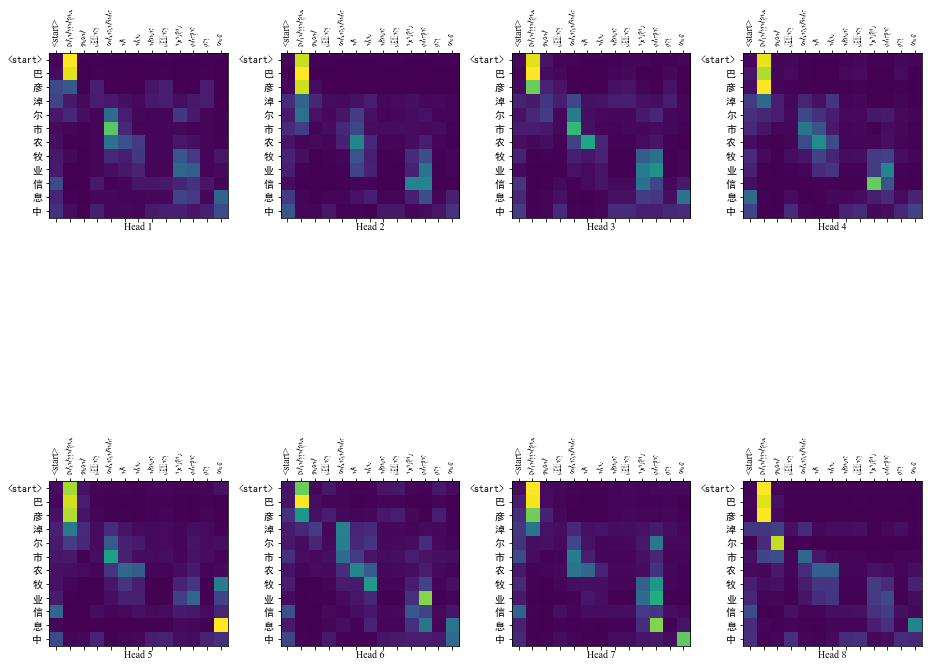

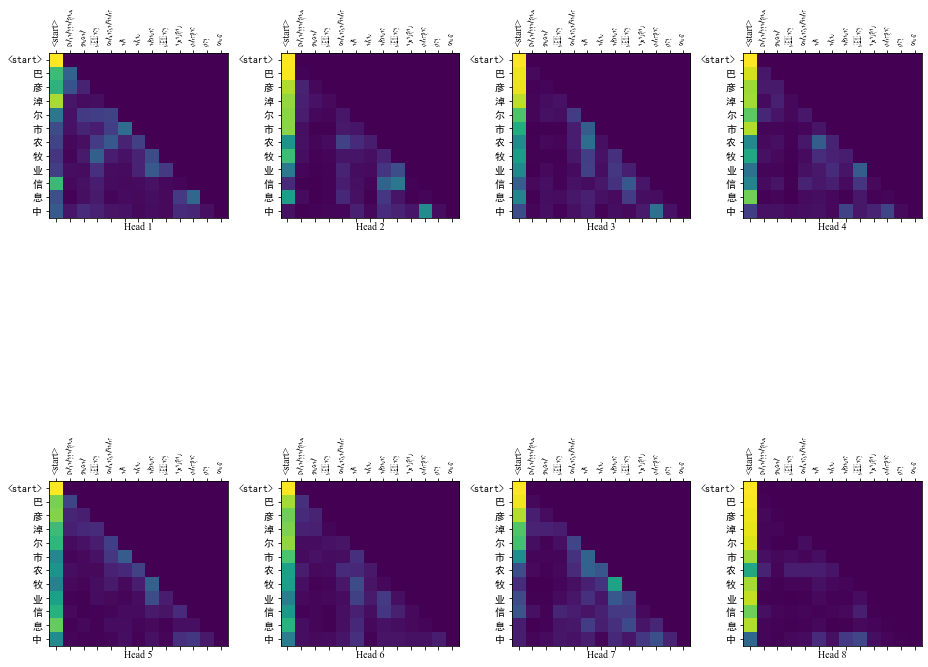

In [162]:
dep = torch.zeros(1)
translate(test_pairs[481], dep, 'decoder_layer5_block2')
translate(test_pairs[481], dep, 'decoder_layer5_block1')

In [163]:
os.rename(result_save[:-1], result_save[:-1]+'_'+str(bleu_score)+'_'+str(seed)+'_'+file_name)

## 19.总结

代码还有以下待完善的地方：
- 没有实现标签平滑
- 在训练过程中使用了teacher-forcing，即总是会将target传递到下一时间步长。更好的做法是设置一个teacher_forcing_ration
- 在evaluate阶段的解码使用的是greedy search decode，即对于每一步，我们只需从具有最高 softmax 值的 decoder_output 中选择单词。可以尝试使用更好的beam search